# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
filename = 'hsd-coreset'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(selected_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5515, Accuracy: 0.8278, F1 Micro: 0.0526, F1 Macro: 0.0182
Epoch 2/10, Train Loss: 0.4092, Accuracy: 0.8295, F1 Micro: 0.0347, F1 Macro: 0.0148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3802, Accuracy: 0.8324, F1 Micro: 0.0695, F1 Macro: 0.0281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3552, Accuracy: 0.8526, F1 Micro: 0.3213, F1 Macro: 0.1074
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.342, Accuracy: 0.8673, F1 Micro: 0.4473, F1 Macro: 0.192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3115, Accuracy: 0.8739, F1 Micro: 0.6072, F1 Macro: 0.2899
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.269, Accuracy: 0.8773, F1 Micro: 0.6207, F1 Macro: 0.3031
Epoch 8/10, Train Loss: 0.2578, Accuracy: 0.8806, F1 Micro: 0.5807, F1 Macro: 0.2899
Epoch 9/10, Train Loss: 0.2221, Accuracy: 0.8783, F1 Micro: 0.5331, F1 Macro: 0.2736
Epoch 10/10, Train Loss: 0.1966, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4989, Accuracy: 0.8146, F1 Micro: 0.5037, F1 Macro: 0.2163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3993, Accuracy: 0.8737, F1 Micro: 0.598, F1 Macro: 0.2737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3472, Accuracy: 0.8868, F1 Micro: 0.6438, F1 Macro: 0.3399
Epoch 4/10, Train Loss: 0.3065, Accuracy: 0.8915, F1 Micro: 0.6047, F1 Macro: 0.3423
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2556, Accuracy: 0.8999, F1 Micro: 0.6694, F1 Macro: 0.4498
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2181, Accuracy: 0.9007, F1 Micro: 0.6821, F1 Macro: 0.4673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1878, Accuracy: 0.9014, F1 Micro: 0.6862, F1 Macro: 0.4905
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1614, Accuracy: 0.9045, F1 Micro: 0.6966, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.135, Accuracy: 0.9027, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.446, Accuracy: 0.8627, F1 Micro: 0.4607, F1 Macro: 0.2099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3044, Accuracy: 0.8859, F1 Micro: 0.5883, F1 Macro: 0.3193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2602, Accuracy: 0.8958, F1 Micro: 0.6487, F1 Macro: 0.4421
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2226, Accuracy: 0.9023, F1 Micro: 0.6828, F1 Macro: 0.5019
Epoch 5/10, Train Loss: 0.1956, Accuracy: 0.9036, F1 Micro: 0.6782, F1 Macro: 0.5062
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1613, Accuracy: 0.9073, F1 Micro: 0.6926, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1312, Accuracy: 0.9085, F1 Micro: 0.7264, F1 Macro: 0.6037
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.9083, F1 Micro: 0.7152, F1 Macro: 0.5876
Epoch 9/10, Train Loss: 0.0925, Accuracy: 0.9078, F1 Micro: 0.718, F1 Macro: 0.6119
Epoch 10/10, Train Loss: 0.0769, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4192, Accuracy: 0.874, F1 Micro: 0.5431, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2992, Accuracy: 0.8898, F1 Micro: 0.6029, F1 Macro: 0.3371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2446, Accuracy: 0.899, F1 Micro: 0.6915, F1 Macro: 0.5328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2025, Accuracy: 0.9082, F1 Micro: 0.7109, F1 Macro: 0.5562
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1664, Accuracy: 0.9124, F1 Micro: 0.7284, F1 Macro: 0.6082
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1345, Accuracy: 0.9047, F1 Micro: 0.7378, F1 Macro: 0.6388
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9123, F1 Micro: 0.7279, F1 Macro: 0.6271
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.9116, F1 Micro: 0.7435, F1 Macro: 0.6606
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9122, F1 Micro: 0.7344, F1 Macro: 0.6714
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4226, Accuracy: 0.8828, F1 Micro: 0.6134, F1 Macro: 0.3163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2867, Accuracy: 0.8999, F1 Micro: 0.6551, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2315, Accuracy: 0.9104, F1 Micro: 0.7093, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1883, Accuracy: 0.9124, F1 Micro: 0.7245, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.9161, F1 Micro: 0.7493, F1 Macro: 0.6448
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9156, F1 Micro: 0.7475, F1 Macro: 0.6574
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.9137, F1 Micro: 0.744, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0904, Accuracy: 0.9129, F1 Micro: 0.7499, F1 Macro: 0.6748
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.915, F1 Micro: 0.741, F1 Macro: 0.6627
Epoch 10/10, Train Loss: 0.0622, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4097, Accuracy: 0.8875, F1 Micro: 0.6048, F1 Macro: 0.3094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2825, Accuracy: 0.9064, F1 Micro: 0.7104, F1 Macro: 0.5217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2262, Accuracy: 0.9161, F1 Micro: 0.7494, F1 Macro: 0.6243
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9166, F1 Micro: 0.7524, F1 Macro: 0.6416
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9166, F1 Micro: 0.7585, F1 Macro: 0.6101
Epoch 6/10, Train Loss: 0.1239, Accuracy: 0.92, F1 Micro: 0.7466, F1 Macro: 0.6497
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9182, F1 Micro: 0.7585, F1 Macro: 0.6768
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9173, F1 Micro: 0.751, F1 Macro: 0.6856
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9196, F1 Micro: 0.757, F1 Macro: 0.6814
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0613, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3955, Accuracy: 0.8874, F1 Micro: 0.5938, F1 Macro: 0.32
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.9033, F1 Micro: 0.7306, F1 Macro: 0.5494
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.9164, F1 Micro: 0.7469, F1 Macro: 0.6231
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9201, F1 Micro: 0.7616, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9202, F1 Micro: 0.7704, F1 Macro: 0.6727
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9189, F1 Micro: 0.7659, F1 Macro: 0.693
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.9178, F1 Micro: 0.7659, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9186, F1 Micro: 0.772, F1 Macro: 0.7068
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.9197, F1 Micro: 0.7613, F1 Macro: 0.6906
Epoch 10/10, Train Loss: 0.0529, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3951, Accuracy: 0.8961, F1 Micro: 0.6664, F1 Macro: 0.4043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.9085, F1 Micro: 0.7339, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9156, F1 Micro: 0.7597, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.921, F1 Micro: 0.765, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9217, F1 Micro: 0.7692, F1 Macro: 0.677
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9221, F1 Micro: 0.7646, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9175, F1 Micro: 0.7711, F1 Macro: 0.6929
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9196, F1 Micro: 0.7598, F1 Macro: 0.6889
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9192, F1 Micro: 0.7603, F1 Macro: 0.6853
Epoch 10/10, Train Loss: 0.0532, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.8966, F1 Micro: 0.6686, F1 Macro: 0.4112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9128, F1 Micro: 0.7243, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9204, F1 Micro: 0.7538, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.92, F1 Micro: 0.7549, F1 Macro: 0.6095
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9221, F1 Micro: 0.7579, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9204, F1 Micro: 0.7734, F1 Macro: 0.6843
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9209, F1 Micro: 0.764, F1 Macro: 0.6863
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.921, F1 Micro: 0.7733, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.923, F1 Micro: 0.7767, F1 Macro: 0.7058
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3751, Accuracy: 0.8967, F1 Micro: 0.6796, F1 Macro: 0.4513
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2451, Accuracy: 0.9104, F1 Micro: 0.73, F1 Macro: 0.5461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9209, F1 Micro: 0.758, F1 Macro: 0.6358
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9204, F1 Micro: 0.7669, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.92, F1 Micro: 0.7699, F1 Macro: 0.6769
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9207, F1 Micro: 0.7659, F1 Macro: 0.687
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.9232, F1 Micro: 0.7698, F1 Macro: 0.696
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9195, F1 Micro: 0.7693, F1 Macro: 0.7088
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9219, F1 Micro: 0.774, F1 Macro: 0.7013
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3619, Accuracy: 0.8997, F1 Micro: 0.6966, F1 Macro: 0.4704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.234, Accuracy: 0.9146, F1 Micro: 0.7278, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9202, F1 Micro: 0.7644, F1 Macro: 0.6385
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9214, F1 Micro: 0.7643, F1 Macro: 0.6461
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9229, F1 Micro: 0.7643, F1 Macro: 0.6632
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9211, F1 Micro: 0.7565, F1 Macro: 0.6729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.922, F1 Micro: 0.7733, F1 Macro: 0.6917
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9189, F1 Micro: 0.7624, F1 Macro: 0.6951
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9218, F1 Micro: 0.7677, F1 Macro: 0.7092
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9222, F1 Micro: 0.7735, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3609, Accuracy: 0.8987, F1 Micro: 0.6718, F1 Macro: 0.4651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.9143, F1 Micro: 0.7372, F1 Macro: 0.5516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1852, Accuracy: 0.9217, F1 Micro: 0.7671, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9214, F1 Micro: 0.7691, F1 Macro: 0.6473
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9239, F1 Micro: 0.7683, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9222, F1 Micro: 0.7789, F1 Macro: 0.6878
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9211, F1 Micro: 0.766, F1 Macro: 0.6994
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9222, F1 Micro: 0.7726, F1 Macro: 0.7069
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9236, F1 Micro: 0.7661, F1 Macro: 0.7089
Epoch 10/10, Train Loss: 0.0488, Accuracy: 0.9231, F1 Micro: 0.7628, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3514, Accuracy: 0.8982, F1 Micro: 0.6497, F1 Macro: 0.385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2285, Accuracy: 0.9141, F1 Micro: 0.7441, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9218, F1 Micro: 0.7582, F1 Macro: 0.6229
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.922, F1 Micro: 0.756, F1 Macro: 0.6338
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9233, F1 Micro: 0.7782, F1 Macro: 0.692
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9232, F1 Micro: 0.7729, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9261, F1 Micro: 0.7819, F1 Macro: 0.7002
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.925, F1 Micro: 0.7731, F1 Macro: 0.7098
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9242, F1 Micro: 0.7779, F1 Macro: 0.7096
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0447, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3518, Accuracy: 0.8983, F1 Micro: 0.6426, F1 Macro: 0.4315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2301, Accuracy: 0.9172, F1 Micro: 0.7368, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.922, F1 Micro: 0.7614, F1 Macro: 0.6154
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9237, F1 Micro: 0.7578, F1 Macro: 0.6579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.9212, F1 Micro: 0.7713, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9197, F1 Micro: 0.7726, F1 Macro: 0.6893
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9246, F1 Micro: 0.779, F1 Macro: 0.7044
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9234, F1 Micro: 0.7739, F1 Macro: 0.705
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9182, F1 Micro: 0.7598, F1 Macro: 0.6994
Epoch 10/10, Train Loss: 0.0448, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3453, Accuracy: 0.9039, F1 Micro: 0.6987, F1 Macro: 0.4828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2287, Accuracy: 0.917, F1 Micro: 0.7546, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9218, F1 Micro: 0.7722, F1 Macro: 0.6495
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9209, F1 Micro: 0.7403, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9233, F1 Micro: 0.7808, F1 Macro: 0.7084
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9254, F1 Micro: 0.7785, F1 Macro: 0.7049
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9218, F1 Micro: 0.7759, F1 Macro: 0.696
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9238, F1 Micro: 0.7719, F1 Macro: 0.7077
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9215, F1 Micro: 0.7758, F1 Macro: 0.722
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.924, F1 Micro: 0.7724, F1 Macro: 0.704

 Iteration 8165: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3425, Accuracy: 0.8978, F1 Micro: 0.6906, F1 Macro: 0.4073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2217, Accuracy: 0.9133, F1 Micro: 0.7264, F1 Macro: 0.5808
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9185, F1 Micro: 0.7548, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9218, F1 Micro: 0.7738, F1 Macro: 0.6769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9208, F1 Micro: 0.777, F1 Macro: 0.7079
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9259, F1 Micro: 0.7761, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9225, F1 Micro: 0.7804, F1 Macro: 0.7146
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9209, F1 Micro: 0.7766, F1 Macro: 0.715
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9256, F1 Micro: 0.7804, F1 Macro: 0.7231
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.346, Accuracy: 0.9027, F1 Micro: 0.6921, F1 Macro: 0.4173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2293, Accuracy: 0.9168, F1 Micro: 0.7537, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9205, F1 Micro: 0.7692, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9222, F1 Micro: 0.7698, F1 Macro: 0.6633
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.923, F1 Micro: 0.7681, F1 Macro: 0.6894
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9248, F1 Micro: 0.7784, F1 Macro: 0.711
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9242, F1 Micro: 0.7768, F1 Macro: 0.7132
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9253, F1 Micro: 0.7721, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9258, F1 Micro: 0.7787, F1 Macro: 0.7169
Epoch 10/10, Train Loss: 0.0443, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.341, Accuracy: 0.9037, F1 Micro: 0.692, F1 Macro: 0.4854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.217, Accuracy: 0.9184, F1 Micro: 0.7517, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9191, F1 Micro: 0.7523, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9262, F1 Micro: 0.7838, F1 Macro: 0.6938
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9213, F1 Micro: 0.7774, F1 Macro: 0.6869
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9253, F1 Micro: 0.7707, F1 Macro: 0.7009
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9261, F1 Micro: 0.7736, F1 Macro: 0.7032
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9207, F1 Micro: 0.7734, F1 Macro: 0.7115
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9265, F1 Micro: 0.7797, F1 Macro: 0.7153
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9264, F1 Micro: 0.7833, F1 Macro: 0.7268

 Iteration 8817: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3394, Accuracy: 0.9019, F1 Micro: 0.6818, F1 Macro: 0.4562
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2178, Accuracy: 0.915, F1 Micro: 0.7361, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.9204, F1 Micro: 0.7539, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.9249, F1 Micro: 0.7781, F1 Macro: 0.6583
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.9245, F1 Micro: 0.7706, F1 Macro: 0.6761
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9255, F1 Micro: 0.7774, F1 Macro: 0.7044
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9229, F1 Micro: 0.7753, F1 Macro: 0.6946
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9241, F1 Micro: 0.7773, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.922, F1 Micro: 0.7792, F1 Macro: 0.7183
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.9233, F1 Micro: 0.7764, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3354, Accuracy: 0.9014, F1 Micro: 0.658, F1 Macro: 0.4171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2205, Accuracy: 0.9168, F1 Micro: 0.7587, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1695, Accuracy: 0.9182, F1 Micro: 0.7719, F1 Macro: 0.6468
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9225, F1 Micro: 0.7763, F1 Macro: 0.6753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9227, F1 Micro: 0.7844, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9271, F1 Micro: 0.788, F1 Macro: 0.7142
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9235, F1 Micro: 0.7809, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9249, F1 Micro: 0.7891, F1 Macro: 0.7289
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9236, F1 Micro: 0.7845, F1 Macro: 0.7248
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3362, Accuracy: 0.9034, F1 Micro: 0.7115, F1 Macro: 0.5089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2185, Accuracy: 0.9132, F1 Micro: 0.7595, F1 Macro: 0.6037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9221, F1 Micro: 0.7652, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9282, F1 Micro: 0.7864, F1 Macro: 0.6972
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.9256, F1 Micro: 0.7808, F1 Macro: 0.6596
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9248, F1 Micro: 0.7841, F1 Macro: 0.6949
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9284, F1 Micro: 0.7839, F1 Macro: 0.7122
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9259, F1 Micro: 0.7787, F1 Macro: 0.7105
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9255, F1 Micro: 0.7866, F1 Macro: 0.729
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9222, F1 Micro: 0.7826, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3371, Accuracy: 0.9029, F1 Micro: 0.7025, F1 Macro: 0.5084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.214, Accuracy: 0.9197, F1 Micro: 0.7555, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9226, F1 Micro: 0.7684, F1 Macro: 0.6244
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9264, F1 Micro: 0.7762, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.926, F1 Micro: 0.7838, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9258, F1 Micro: 0.7852, F1 Macro: 0.7071
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9259, F1 Micro: 0.7858, F1 Macro: 0.7167
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9262, F1 Micro: 0.7806, F1 Macro: 0.7027
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9248, F1 Micro: 0.7825, F1 Macro: 0.7118
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3334, Accuracy: 0.9081, F1 Micro: 0.7221, F1 Macro: 0.5156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.9167, F1 Micro: 0.7547, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9216, F1 Micro: 0.7762, F1 Macro: 0.6466
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1388, Accuracy: 0.9258, F1 Micro: 0.7882, F1 Macro: 0.6866
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9257, F1 Micro: 0.7852, F1 Macro: 0.6929
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9262, F1 Micro: 0.7799, F1 Macro: 0.7052
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9248, F1 Micro: 0.7757, F1 Macro: 0.7055
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9262, F1 Micro: 0.7773, F1 Macro: 0.7165
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9282, F1 Micro: 0.7866, F1 Macro: 0.7287
Epoch 10/10, Train Loss: 0.0399, Accuracy: 0.9258, F1 Micro: 0.7849, F1 Macro: 0.7246

 Iteration 9618:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3328, Accuracy: 0.9007, F1 Micro: 0.6776, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.917, F1 Micro: 0.7272, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9256, F1 Micro: 0.7734, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9213, F1 Micro: 0.7746, F1 Macro: 0.6647
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9256, F1 Micro: 0.7746, F1 Macro: 0.6712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9275, F1 Micro: 0.7774, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9239, F1 Micro: 0.7889, F1 Macro: 0.723
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9275, F1 Micro: 0.7837, F1 Macro: 0.7225
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9266, F1 Micro: 0.7872, F1 Macro: 0.7185
Epoch 10/10, Train Loss: 0.0434, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3302, Accuracy: 0.9054, F1 Micro: 0.718, F1 Macro: 0.4944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2119, Accuracy: 0.9184, F1 Micro: 0.7612, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9235, F1 Micro: 0.7849, F1 Macro: 0.6574
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9268, F1 Micro: 0.7845, F1 Macro: 0.6797
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.927, F1 Micro: 0.7801, F1 Macro: 0.7041
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9263, F1 Micro: 0.7856, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9266, F1 Micro: 0.7892, F1 Macro: 0.719
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9256, F1 Micro: 0.7711, F1 Macro: 0.6994
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9238, F1 Micro: 0.7808, F1 Macro: 0.7128
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9259, F1 Micro: 0.7818, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3297, Accuracy: 0.9026, F1 Micro: 0.6908, F1 Macro: 0.4248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2188, Accuracy: 0.9194, F1 Micro: 0.7584, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1676, Accuracy: 0.9259, F1 Micro: 0.7748, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1355, Accuracy: 0.9253, F1 Micro: 0.7786, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9264, F1 Micro: 0.7907, F1 Macro: 0.7091
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9273, F1 Micro: 0.782, F1 Macro: 0.7129
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9302, F1 Micro: 0.7942, F1 Macro: 0.7129
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9262, F1 Micro: 0.7861, F1 Macro: 0.7205
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9273, F1 Micro: 0.7872, F1 Macro: 0.723
Epoch 10/10, Train Loss: 0.0397, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3293, Accuracy: 0.9067, F1 Micro: 0.703, F1 Macro: 0.5042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2189, Accuracy: 0.9207, F1 Micro: 0.7686, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9264, F1 Micro: 0.7776, F1 Macro: 0.6345
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1334, Accuracy: 0.9271, F1 Micro: 0.7837, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9271, F1 Micro: 0.7904, F1 Macro: 0.7127
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9255, F1 Micro: 0.786, F1 Macro: 0.7098
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9299, F1 Micro: 0.7897, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9301, F1 Micro: 0.7947, F1 Macro: 0.735
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9298, F1 Micro: 0.7937, F1 Macro: 0.7308
Epoch 10/10, Train Loss: 0.0395, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3267, Accuracy: 0.9075, F1 Micro: 0.7034, F1 Macro: 0.5195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.916, F1 Micro: 0.7582, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1725, Accuracy: 0.9248, F1 Micro: 0.7792, F1 Macro: 0.6341
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1344, Accuracy: 0.9274, F1 Micro: 0.7873, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9263, F1 Micro: 0.7875, F1 Macro: 0.6921
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9284, F1 Micro: 0.7827, F1 Macro: 0.688
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9285, F1 Micro: 0.7872, F1 Macro: 0.7241
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9259, F1 Micro: 0.7865, F1 Macro: 0.7199
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9253, F1 Micro: 0.7818, F1 Macro: 0.715
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9248, F1 Micro: 0.7841, F1 M

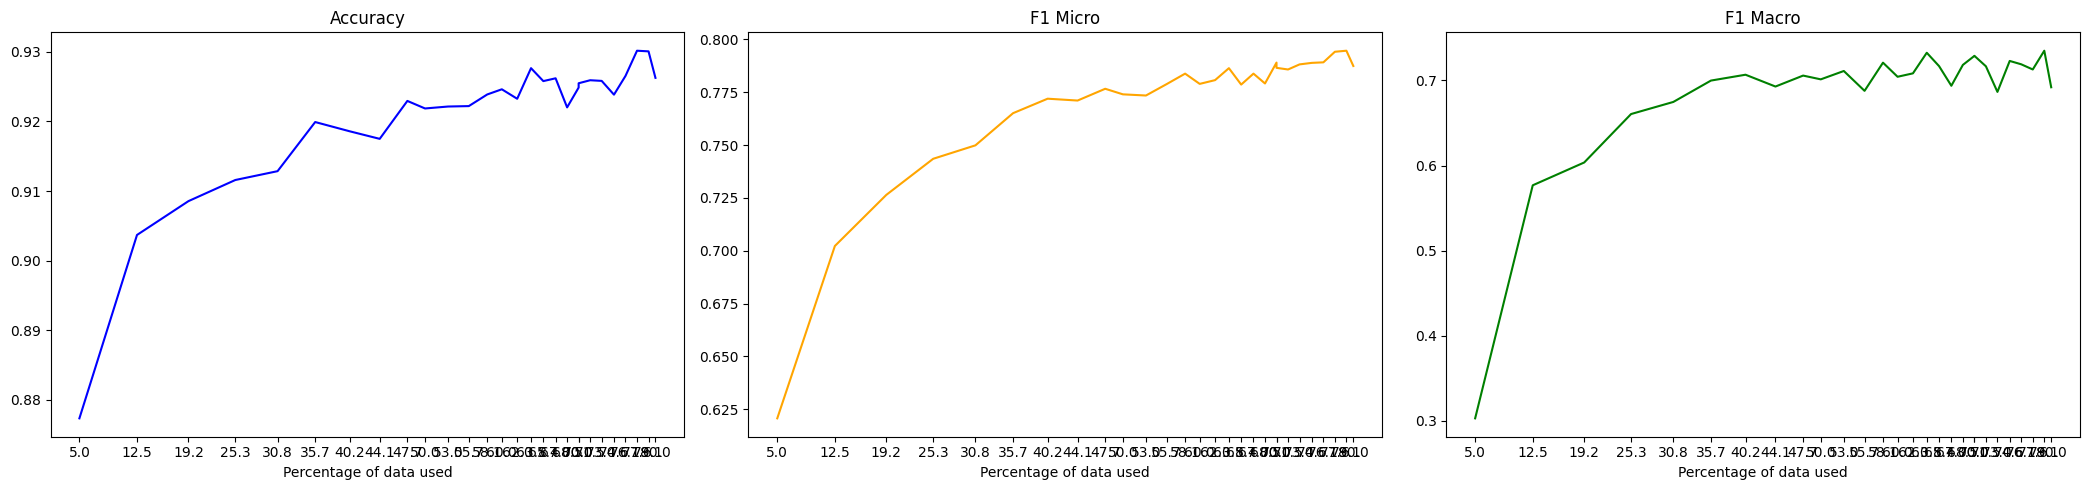

In [23]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5266, Accuracy: 0.8301, F1 Micro: 0.2891, F1 Macro: 0.0662
Epoch 2/10, Train Loss: 0.3942, Accuracy: 0.8359, F1 Micro: 0.1442, F1 Macro: 0.0503
Epoch 3/10, Train Loss: 0.3671, Accuracy: 0.8486, F1 Micro: 0.2855, F1 Macro: 0.1017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3413, Accuracy: 0.867, F1 Micro: 0.4893, F1 Macro: 0.2134
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3096, Accuracy: 0.8779, F1 Micro: 0.5722, F1 Macro: 0.2657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2733, Accuracy: 0.8816, F1 Micro: 0.5875, F1 Macro: 0.2778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2475, Accuracy: 0.8853, F1 Micro: 0.601, F1 Macro: 0.2967
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2294, Accuracy: 0.888, F1 Micro: 0.6436, F1 Macro: 0.3443
Epoch 9/10, Train Loss: 0.198, Accuracy: 0.8897, F1 Micro: 0.6336, F1 Macro: 0.3385
Epoch 10/10, Train Loss: 0.1811, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4942, Accuracy: 0.8162, F1 Micro: 0.5136, F1 Macro: 0.2231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3862, Accuracy: 0.8638, F1 Micro: 0.5934, F1 Macro: 0.2968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3279, Accuracy: 0.8848, F1 Micro: 0.6275, F1 Macro: 0.3623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2887, Accuracy: 0.8964, F1 Micro: 0.6501, F1 Macro: 0.4151
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2444, Accuracy: 0.9004, F1 Micro: 0.6513, F1 Macro: 0.4586
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2103, Accuracy: 0.9032, F1 Micro: 0.6771, F1 Macro: 0.5213
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.178, Accuracy: 0.9027, F1 Micro: 0.6879, F1 Macro: 0.524
Epoch 8/10, Train Loss: 0.1526, Accuracy: 0.9017, F1 Micro: 0.6796, F1 Macro: 0.5499
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1285, Accuracy: 0.9045, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4541, Accuracy: 0.8407, F1 Micro: 0.5168, F1 Macro: 0.2267
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3423, Accuracy: 0.891, F1 Micro: 0.6395, F1 Macro: 0.3554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2732, Accuracy: 0.9017, F1 Micro: 0.6919, F1 Macro: 0.4725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.231, Accuracy: 0.9077, F1 Micro: 0.702, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1918, Accuracy: 0.9068, F1 Micro: 0.7145, F1 Macro: 0.5573
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1567, Accuracy: 0.9081, F1 Micro: 0.7171, F1 Macro: 0.577
Epoch 7/10, Train Loss: 0.1291, Accuracy: 0.9077, F1 Micro: 0.7016, F1 Macro: 0.5665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.113, Accuracy: 0.9051, F1 Micro: 0.7274, F1 Macro: 0.5982
Epoch 9/10, Train Loss: 0.0927, Accuracy: 0.9102, F1 Micro: 0.7169, F1 Macro: 0.5936
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.8784, F1 Micro: 0.5332, F1 Macro: 0.2417
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.899, F1 Micro: 0.6663, F1 Macro: 0.3815
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9023, F1 Micro: 0.6605, F1 Macro: 0.4598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9095, F1 Micro: 0.7142, F1 Macro: 0.5218
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9108, F1 Micro: 0.7056, F1 Macro: 0.5361
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.9105, F1 Micro: 0.7002, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9127, F1 Micro: 0.7263, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9128, F1 Micro: 0.7326, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9155, F1 Micro: 0.7414, F1 Macro: 0.6372
Epoch 10/10, Train Loss: 0.0623, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4191, Accuracy: 0.8892, F1 Micro: 0.6434, F1 Macro: 0.3982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2888, Accuracy: 0.9042, F1 Micro: 0.7039, F1 Macro: 0.509
Epoch 3/10, Train Loss: 0.2247, Accuracy: 0.9092, F1 Micro: 0.6937, F1 Macro: 0.554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9123, F1 Micro: 0.7414, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1527, Accuracy: 0.9165, F1 Micro: 0.742, F1 Macro: 0.619
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9153, F1 Micro: 0.7374, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9165, F1 Micro: 0.7469, F1 Macro: 0.6575
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9151, F1 Micro: 0.7211, F1 Macro: 0.6485
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9156, F1 Micro: 0.7485, F1 Macro: 0.6799
Epoch 10/10, Train Loss: 0.0622, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4083, Accuracy: 0.8881, F1 Micro: 0.6617, F1 Macro: 0.4419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2784, Accuracy: 0.9092, F1 Micro: 0.7158, F1 Macro: 0.5483
Epoch 3/10, Train Loss: 0.2254, Accuracy: 0.9123, F1 Micro: 0.7108, F1 Macro: 0.5523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9177, F1 Micro: 0.7453, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9171, F1 Micro: 0.754, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9191, F1 Micro: 0.7556, F1 Macro: 0.6413
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9201, F1 Micro: 0.7521, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9192, F1 Micro: 0.7594, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9159, F1 Micro: 0.7572, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3851, Accuracy: 0.887, F1 Micro: 0.5682, F1 Macro: 0.3184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.9093, F1 Micro: 0.7231, F1 Macro: 0.5379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9155, F1 Micro: 0.7362, F1 Macro: 0.5989
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.918, F1 Micro: 0.7402, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9186, F1 Micro: 0.7557, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9152, F1 Micro: 0.7572, F1 Macro: 0.6558
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9195, F1 Micro: 0.7486, F1 Macro: 0.6547
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.92, F1 Micro: 0.7506, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9194, F1 Micro: 0.7572, F1 Macro: 0.6929
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3826, Accuracy: 0.8934, F1 Micro: 0.6886, F1 Macro: 0.4392
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9114, F1 Micro: 0.7315, F1 Macro: 0.5698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9175, F1 Micro: 0.7363, F1 Macro: 0.5956
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9155, F1 Micro: 0.751, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9191, F1 Micro: 0.7625, F1 Macro: 0.6423
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9193, F1 Micro: 0.7592, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9214, F1 Micro: 0.7668, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.074, Accuracy: 0.9219, F1 Micro: 0.7692, F1 Macro: 0.6915
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9182, F1 Micro: 0.7624, F1 Macro: 0.6982
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3672, Accuracy: 0.899, F1 Micro: 0.68, F1 Macro: 0.475
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2352, Accuracy: 0.9121, F1 Micro: 0.7294, F1 Macro: 0.5649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9169, F1 Micro: 0.7459, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9211, F1 Micro: 0.7581, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.9188, F1 Micro: 0.7621, F1 Macro: 0.6481
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9187, F1 Micro: 0.7667, F1 Macro: 0.6814
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9138, F1 Micro: 0.7582, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9218, F1 Micro: 0.7714, F1 Macro: 0.7013
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9154, F1 Micro: 0.7629, F1 Macro: 0.6964
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3562, Accuracy: 0.9002, F1 Micro: 0.6895, F1 Macro: 0.4622
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2341, Accuracy: 0.9077, F1 Micro: 0.7357, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.9188, F1 Micro: 0.7664, F1 Macro: 0.6135
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9207, F1 Micro: 0.7585, F1 Macro: 0.6492
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9226, F1 Micro: 0.7655, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9242, F1 Micro: 0.7744, F1 Macro: 0.6809
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9204, F1 Micro: 0.7712, F1 Macro: 0.6928
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9231, F1 Micro: 0.7633, F1 Macro: 0.6857
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9234, F1 Micro: 0.7673, F1 Macro: 0.7033
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.9222, F1 Micro: 0.7682, F1 Macro: 0.7117

 Iteration 6584:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3463, Accuracy: 0.899, F1 Micro: 0.6925, F1 Macro: 0.4972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2259, Accuracy: 0.9029, F1 Micro: 0.7295, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9192, F1 Micro: 0.7445, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9217, F1 Micro: 0.7602, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9234, F1 Micro: 0.7692, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0956, Accuracy: 0.9229, F1 Micro: 0.7721, F1 Macro: 0.6912
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.924, F1 Micro: 0.7642, F1 Macro: 0.6763
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9211, F1 Micro: 0.7678, F1 Macro: 0.6956
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9232, F1 Micro: 0.7669, F1 Macro: 0.703
Epoch 10/10, Train Loss: 0.0449, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3537, Accuracy: 0.896, F1 Micro: 0.7123, F1 Macro: 0.5179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.9127, F1 Micro: 0.7374, F1 Macro: 0.5566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9196, F1 Micro: 0.7445, F1 Macro: 0.59
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9227, F1 Micro: 0.7678, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9237, F1 Micro: 0.7752, F1 Macro: 0.6626
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9259, F1 Micro: 0.7733, F1 Macro: 0.6696
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9247, F1 Micro: 0.7735, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9253, F1 Micro: 0.7799, F1 Macro: 0.7094
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9243, F1 Micro: 0.7732, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3453, Accuracy: 0.903, F1 Micro: 0.6928, F1 Macro: 0.4782
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2226, Accuracy: 0.9157, F1 Micro: 0.7286, F1 Macro: 0.5656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9212, F1 Micro: 0.7605, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.9231, F1 Micro: 0.7759, F1 Macro: 0.6534
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9234, F1 Micro: 0.76, F1 Macro: 0.6611
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9244, F1 Micro: 0.7752, F1 Macro: 0.6981
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9253, F1 Micro: 0.771, F1 Macro: 0.6969
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9245, F1 Micro: 0.7718, F1 Macro: 0.6972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9239, F1 Micro: 0.783, F1 Macro: 0.7162
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9235, F1 Micro: 0.7778, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3401, Accuracy: 0.8984, F1 Micro: 0.7071, F1 Macro: 0.5043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2209, Accuracy: 0.9129, F1 Micro: 0.7482, F1 Macro: 0.5808
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9219, F1 Micro: 0.7466, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9203, F1 Micro: 0.7739, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9216, F1 Micro: 0.7769, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9274, F1 Micro: 0.7828, F1 Macro: 0.6895
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9243, F1 Micro: 0.7796, F1 Macro: 0.7101
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9253, F1 Micro: 0.7739, F1 Macro: 0.6934
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9257, F1 Micro: 0.7686, F1 Macro: 0.706
Epoch 10/10, Train Loss: 0.0417, Accuracy: 0.9241, F1 Micro: 0.7787, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3447, Accuracy: 0.9034, F1 Micro: 0.6778, F1 Macro: 0.4234
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2236, Accuracy: 0.9165, F1 Micro: 0.7542, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9217, F1 Micro: 0.7718, F1 Macro: 0.6263
Epoch 4/10, Train Loss: 0.1399, Accuracy: 0.9217, F1 Micro: 0.7549, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9237, F1 Micro: 0.7784, F1 Macro: 0.6441
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9127, F1 Micro: 0.7627, F1 Macro: 0.679
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9197, F1 Micro: 0.7752, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9277, F1 Micro: 0.7876, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9241, F1 Micro: 0.7847, F1 Macro: 0.7178
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0455, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3407, Accuracy: 0.9027, F1 Micro: 0.666, F1 Macro: 0.4696
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.9159, F1 Micro: 0.7447, F1 Macro: 0.552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1712, Accuracy: 0.922, F1 Micro: 0.7732, F1 Macro: 0.623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1386, Accuracy: 0.9249, F1 Micro: 0.7814, F1 Macro: 0.6648
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9254, F1 Micro: 0.7753, F1 Macro: 0.6647
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9195, F1 Micro: 0.7688, F1 Macro: 0.6871
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9262, F1 Micro: 0.7822, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9267, F1 Micro: 0.7824, F1 Macro: 0.7097
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.922, F1 Micro: 0.7646, F1 Macro: 0.6945
Epoch 10/10, Train Loss: 0.0419, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3349, Accuracy: 0.9072, F1 Micro: 0.7165, F1 Macro: 0.5185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.9157, F1 Micro: 0.7434, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9196, F1 Micro: 0.7727, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.927, F1 Micro: 0.7842, F1 Macro: 0.6587
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9268, F1 Micro: 0.779, F1 Macro: 0.6728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9258, F1 Micro: 0.7846, F1 Macro: 0.6932
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9274, F1 Micro: 0.7844, F1 Macro: 0.7097
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9244, F1 Micro: 0.7833, F1 Macro: 0.7161
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9226, F1 Micro: 0.7848, F1 Macro: 0.7204
Epoch 10/10, Train Loss: 0.0418, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3346, Accuracy: 0.906, F1 Micro: 0.7043, F1 Macro: 0.5029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2171, Accuracy: 0.9161, F1 Micro: 0.7524, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9249, F1 Micro: 0.7771, F1 Macro: 0.6387
Epoch 4/10, Train Loss: 0.1362, Accuracy: 0.9223, F1 Micro: 0.7765, F1 Macro: 0.6734
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9263, F1 Micro: 0.7769, F1 Macro: 0.6723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9249, F1 Micro: 0.7807, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9252, F1 Micro: 0.7836, F1 Macro: 0.7098
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9252, F1 Micro: 0.7769, F1 Macro: 0.7031
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9251, F1 Micro: 0.7787, F1 Macro: 0.721
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.9238, F1 Micro: 0.7798, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3366, Accuracy: 0.9059, F1 Micro: 0.7146, F1 Macro: 0.5088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2153, Accuracy: 0.9185, F1 Micro: 0.7468, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1716, Accuracy: 0.923, F1 Micro: 0.7562, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9206, F1 Micro: 0.7802, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.9245, F1 Micro: 0.7843, F1 Macro: 0.6726
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9262, F1 Micro: 0.7801, F1 Macro: 0.6841
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9264, F1 Micro: 0.7736, F1 Macro: 0.6961
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9267, F1 Micro: 0.7836, F1 Macro: 0.725
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.924, F1 Micro: 0.7819, F1 Macro: 0.7189
Epoch 10/10, Train Loss: 0.0449, Accuracy: 0.9269, F1 Micro: 0.7835, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.336, Accuracy: 0.9073, F1 Micro: 0.7125, F1 Macro: 0.5172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2193, Accuracy: 0.9189, F1 Micro: 0.7573, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9262, F1 Micro: 0.7789, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9241, F1 Micro: 0.7824, F1 Macro: 0.6583
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9202, F1 Micro: 0.779, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9273, F1 Micro: 0.7836, F1 Macro: 0.6991
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.925, F1 Micro: 0.7809, F1 Macro: 0.7027
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9266, F1 Micro: 0.7858, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9265, F1 Micro: 0.7871, F1 Macro: 0.7268
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3318, Accuracy: 0.9047, F1 Micro: 0.6852, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.9203, F1 Micro: 0.7577, F1 Macro: 0.5815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9237, F1 Micro: 0.7701, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9279, F1 Micro: 0.7878, F1 Macro: 0.6653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9244, F1 Micro: 0.7897, F1 Macro: 0.6939
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9245, F1 Micro: 0.7845, F1 Macro: 0.7015
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9225, F1 Micro: 0.7819, F1 Macro: 0.7034
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9253, F1 Micro: 0.7853, F1 Macro: 0.7186
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9249, F1 Micro: 0.777, F1 Macro: 0.71
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9245, F1 Micro: 0.7793, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3347, Accuracy: 0.907, F1 Micro: 0.6968, F1 Macro: 0.5063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.223, Accuracy: 0.9177, F1 Micro: 0.7534, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9238, F1 Micro: 0.7726, F1 Macro: 0.6249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9231, F1 Micro: 0.7824, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9287, F1 Micro: 0.7848, F1 Macro: 0.6834
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9261, F1 Micro: 0.7806, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9289, F1 Micro: 0.7892, F1 Macro: 0.7161
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9276, F1 Micro: 0.786, F1 Macro: 0.7183
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9287, F1 Micro: 0.7848, F1 Macro: 0.7214
Epoch 10/10, Train Loss: 0.0441, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.334, Accuracy: 0.9039, F1 Micro: 0.7069, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2135, Accuracy: 0.9173, F1 Micro: 0.751, F1 Macro: 0.5581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.926, F1 Micro: 0.7809, F1 Macro: 0.6415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9285, F1 Micro: 0.7844, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9243, F1 Micro: 0.7849, F1 Macro: 0.693
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9225, F1 Micro: 0.7848, F1 Macro: 0.695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.927, F1 Micro: 0.7879, F1 Macro: 0.7137
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9265, F1 Micro: 0.7849, F1 Macro: 0.7167
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9266, F1 Micro: 0.7891, F1 Macro: 0.7228
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3313, Accuracy: 0.9063, F1 Micro: 0.6939, F1 Macro: 0.5029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2217, Accuracy: 0.9147, F1 Micro: 0.7116, F1 Macro: 0.5685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.9231, F1 Micro: 0.7606, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.9264, F1 Micro: 0.7672, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.9282, F1 Micro: 0.7916, F1 Macro: 0.6959
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.928, F1 Micro: 0.788, F1 Macro: 0.7038
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9272, F1 Micro: 0.786, F1 Macro: 0.7103
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9286, F1 Micro: 0.7854, F1 Macro: 0.7213
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9284, F1 Micro: 0.7876, F1 Macro: 0.7257
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.9239, F1 Micro: 0.7872, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.9086, F1 Micro: 0.7191, F1 Macro: 0.5216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.9207, F1 Micro: 0.7637, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9258, F1 Micro: 0.7719, F1 Macro: 0.631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1395, Accuracy: 0.9269, F1 Micro: 0.7872, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9311, F1 Micro: 0.7942, F1 Macro: 0.7003
Epoch 6/10, Train Loss: 0.0885, Accuracy: 0.9261, F1 Micro: 0.7857, F1 Macro: 0.7032
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9284, F1 Micro: 0.7886, F1 Macro: 0.7152
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9292, F1 Micro: 0.7931, F1 Macro: 0.7234
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9259, F1 Micro: 0.7908, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0436, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.328, Accuracy: 0.9091, F1 Micro: 0.7135, F1 Macro: 0.5018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.9194, F1 Micro: 0.7605, F1 Macro: 0.5835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9258, F1 Micro: 0.7821, F1 Macro: 0.6297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9248, F1 Micro: 0.7867, F1 Macro: 0.6705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9278, F1 Micro: 0.787, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9298, F1 Micro: 0.7937, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9293, F1 Micro: 0.7939, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9318, F1 Micro: 0.7982, F1 Macro: 0.7292
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9295, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3218, Accuracy: 0.9055, F1 Micro: 0.7022, F1 Macro: 0.4666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2195, Accuracy: 0.9192, F1 Micro: 0.7611, F1 Macro: 0.6071
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9263, F1 Micro: 0.7765, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1409, Accuracy: 0.9285, F1 Micro: 0.7825, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9287, F1 Micro: 0.7908, F1 Macro: 0.6878
Epoch 6/10, Train Loss: 0.0866, Accuracy: 0.9235, F1 Micro: 0.7845, F1 Macro: 0.6738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9286, F1 Micro: 0.7946, F1 Macro: 0.7128
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9257, F1 Micro: 0.7892, F1 Macro: 0.7252
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9258, F1 Micro: 0.7873, F1 Macro: 0.7237
Epoch 10/10, Train Loss: 0.042, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.325, Accuracy: 0.9079, F1 Micro: 0.7063, F1 Macro: 0.4889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2151, Accuracy: 0.9205, F1 Micro: 0.7608, F1 Macro: 0.59
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.925, F1 Micro: 0.7837, F1 Macro: 0.6534
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9262, F1 Micro: 0.783, F1 Macro: 0.6465
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.109, Accuracy: 0.9237, F1 Micro: 0.7854, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.9285, F1 Micro: 0.7877, F1 Macro: 0.7072
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9299, F1 Micro: 0.7979, F1 Macro: 0.724
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.929, F1 Micro: 0.7874, F1 Macro: 0.7126
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9244, F1 Micro: 0.7861, F1 Macro: 0.7139
Epoch 10/10, Train Loss: 0.0425, Accuracy: 0.9296,

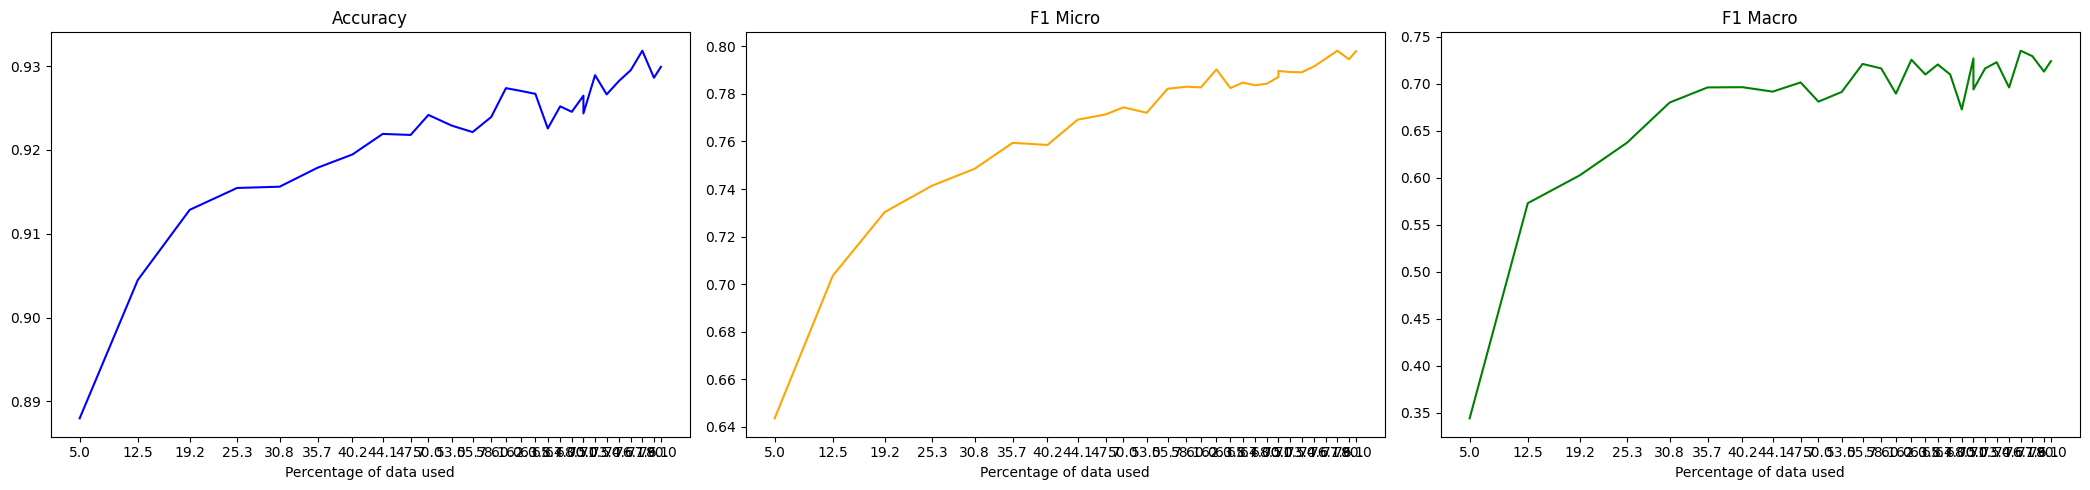

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5457, Accuracy: 0.8292, F1 Micro: 0.0597, F1 Macro: 0.0209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4144, Accuracy: 0.8424, F1 Micro: 0.221, F1 Macro: 0.0713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3893, Accuracy: 0.8443, F1 Micro: 0.2286, F1 Macro: 0.0808
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3533, Accuracy: 0.8603, F1 Micro: 0.4071, F1 Macro: 0.157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3123, Accuracy: 0.8733, F1 Micro: 0.5274, F1 Macro: 0.2581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2824, Accuracy: 0.8793, F1 Micro: 0.5722, F1 Macro: 0.2897
Epoch 7/10, Train Loss: 0.2589, Accuracy: 0.874, F1 Micro: 0.495, F1 Macro: 0.2627
Epoch 8/10, Train Loss: 0.2342, Accuracy: 0.881, F1 Micro: 0.5512, F1 Macro: 0.3126
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2061, Accuracy: 0.8889, F1 Micro: 0.6174, F1 Macro: 0.3491
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4792, Accuracy: 0.8171, F1 Micro: 0.5062, F1 Macro: 0.2233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3769, Accuracy: 0.8702, F1 Micro: 0.5836, F1 Macro: 0.2709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3339, Accuracy: 0.8861, F1 Micro: 0.6229, F1 Macro: 0.309
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2856, Accuracy: 0.893, F1 Micro: 0.6475, F1 Macro: 0.3712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2469, Accuracy: 0.8962, F1 Micro: 0.6659, F1 Macro: 0.405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2205, Accuracy: 0.899, F1 Micro: 0.6674, F1 Macro: 0.4377
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1919, Accuracy: 0.8995, F1 Micro: 0.6767, F1 Macro: 0.4465
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1646, Accuracy: 0.9004, F1 Micro: 0.6887, F1 Macro: 0.512
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.13

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4521, Accuracy: 0.8675, F1 Micro: 0.4885, F1 Macro: 0.2193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3213, Accuracy: 0.889, F1 Micro: 0.6201, F1 Macro: 0.3766
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2678, Accuracy: 0.8978, F1 Micro: 0.6523, F1 Macro: 0.4499
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2315, Accuracy: 0.9014, F1 Micro: 0.6872, F1 Macro: 0.5325
Epoch 5/10, Train Loss: 0.1918, Accuracy: 0.9045, F1 Micro: 0.6752, F1 Macro: 0.5239
Epoch 6/10, Train Loss: 0.1615, Accuracy: 0.9056, F1 Micro: 0.685, F1 Macro: 0.5525
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1324, Accuracy: 0.9046, F1 Micro: 0.6969, F1 Macro: 0.5663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1158, Accuracy: 0.9074, F1 Micro: 0.7177, F1 Macro: 0.6177
Epoch 9/10, Train Loss: 0.0943, Accuracy: 0.9047, F1 Micro: 0.6938, F1 Macro: 0.5971
Epoch 10/10, Train Loss: 0.0868, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4337, Accuracy: 0.8789, F1 Micro: 0.5801, F1 Macro: 0.2905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3038, Accuracy: 0.8952, F1 Micro: 0.6886, F1 Macro: 0.4778
Epoch 3/10, Train Loss: 0.2479, Accuracy: 0.9025, F1 Micro: 0.6703, F1 Macro: 0.5091
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9081, F1 Micro: 0.7019, F1 Macro: 0.5344
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1681, Accuracy: 0.9095, F1 Micro: 0.7096, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.9051, F1 Micro: 0.7341, F1 Macro: 0.6218
Epoch 7/10, Train Loss: 0.1164, Accuracy: 0.9101, F1 Micro: 0.731, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9107, F1 Micro: 0.7408, F1 Macro: 0.6407
Epoch 9/10, Train Loss: 0.0821, Accuracy: 0.9136, F1 Micro: 0.7313, F1 Macro: 0.6455
Epoch 10/10, Train Loss: 0.0724, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.8869, F1 Micro: 0.6279, F1 Macro: 0.3538
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2834, Accuracy: 0.9029, F1 Micro: 0.7005, F1 Macro: 0.4883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2314, Accuracy: 0.907, F1 Micro: 0.7383, F1 Macro: 0.5737
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.913, F1 Micro: 0.7198, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1547, Accuracy: 0.9174, F1 Micro: 0.7463, F1 Macro: 0.599
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.915, F1 Micro: 0.7511, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.915, F1 Micro: 0.7527, F1 Macro: 0.6628
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9184, F1 Micro: 0.7412, F1 Macro: 0.6595
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9174, F1 Micro: 0.7525, F1 Macro: 0.6846
Epoch 10/10, Train Loss: 0.0643, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8894, F1 Micro: 0.6508, F1 Macro: 0.3666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.9036, F1 Micro: 0.708, F1 Macro: 0.5106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9127, F1 Micro: 0.719, F1 Macro: 0.5348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9134, F1 Micro: 0.7494, F1 Macro: 0.6093
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9201, F1 Micro: 0.7493, F1 Macro: 0.6412
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9158, F1 Micro: 0.7332, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9188, F1 Micro: 0.7594, F1 Macro: 0.652
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9176, F1 Micro: 0.7555, F1 Macro: 0.6786
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9205, F1 Micro: 0.7588, F1 Macro: 0.6878
Epoch 10/10, Train Loss: 0.0584, Accuracy: 0.9183, F1 Micro: 0.7558, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8943, F1 Micro: 0.6435, F1 Macro: 0.4059
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.9067, F1 Micro: 0.7183, F1 Macro: 0.551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9141, F1 Micro: 0.7469, F1 Macro: 0.598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9173, F1 Micro: 0.751, F1 Macro: 0.6186
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9202, F1 Micro: 0.7536, F1 Macro: 0.6459
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9194, F1 Micro: 0.7548, F1 Macro: 0.6652
Epoch 7/10, Train Loss: 0.0894, Accuracy: 0.9195, F1 Micro: 0.7518, F1 Macro: 0.6682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.922, F1 Micro: 0.7664, F1 Macro: 0.6949
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9204, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3756, Accuracy: 0.8947, F1 Micro: 0.6363, F1 Macro: 0.4052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2465, Accuracy: 0.9085, F1 Micro: 0.7241, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.917, F1 Micro: 0.757, F1 Macro: 0.5997
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9195, F1 Micro: 0.7563, F1 Macro: 0.6125
Epoch 5/10, Train Loss: 0.1286, Accuracy: 0.9206, F1 Micro: 0.7506, F1 Macro: 0.6401
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1092, Accuracy: 0.9191, F1 Micro: 0.7602, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9206, F1 Micro: 0.7704, F1 Macro: 0.684
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9195, F1 Micro: 0.761, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.92, F1 Micro: 0.7705, F1 Macro: 0.701
Epoch 10/10, Train Loss: 0.0504, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3634, Accuracy: 0.8941, F1 Micro: 0.6937, F1 Macro: 0.4621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2332, Accuracy: 0.9095, F1 Micro: 0.7353, F1 Macro: 0.5668
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9163, F1 Micro: 0.7371, F1 Macro: 0.5873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9172, F1 Micro: 0.7559, F1 Macro: 0.6245
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9209, F1 Micro: 0.7531, F1 Macro: 0.6444
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.92, F1 Micro: 0.7684, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9217, F1 Micro: 0.7709, F1 Macro: 0.6908
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9217, F1 Micro: 0.7639, F1 Macro: 0.6839
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9202, F1 Micro: 0.7598, F1 Macro: 0.6949
Epoch 10/10, Train Loss: 0.0471, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3587, Accuracy: 0.8996, F1 Micro: 0.6839, F1 Macro: 0.4384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2416, Accuracy: 0.9107, F1 Micro: 0.7064, F1 Macro: 0.5079
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.9181, F1 Micro: 0.75, F1 Macro: 0.5748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9222, F1 Micro: 0.7754, F1 Macro: 0.6696
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9235, F1 Micro: 0.7731, F1 Macro: 0.6646
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9256, F1 Micro: 0.7741, F1 Macro: 0.6762
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9211, F1 Micro: 0.7726, F1 Macro: 0.6991
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9212, F1 Micro: 0.7752, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9246, F1 Micro: 0.7776, F1 Macro: 0.7094
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.9216, F1 Micro: 0.7618, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3592, Accuracy: 0.9013, F1 Micro: 0.6766, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9153, F1 Micro: 0.7451, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9153, F1 Micro: 0.7627, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.9211, F1 Micro: 0.7718, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9235, F1 Micro: 0.776, F1 Macro: 0.6642
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9238, F1 Micro: 0.7708, F1 Macro: 0.688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9257, F1 Micro: 0.782, F1 Macro: 0.7025
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9238, F1 Micro: 0.7714, F1 Macro: 0.7017
Epoch 9/10, Train Loss: 0.0586, Accuracy: 0.9222, F1 Micro: 0.7767, F1 Macro: 0.7114
Epoch 10/10, Train Loss: 0.0502, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3578, Accuracy: 0.9024, F1 Micro: 0.6781, F1 Macro: 0.4676
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.916, F1 Micro: 0.7258, F1 Macro: 0.563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9233, F1 Micro: 0.7717, F1 Macro: 0.6323
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9209, F1 Micro: 0.7711, F1 Macro: 0.6481
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9243, F1 Micro: 0.7631, F1 Macro: 0.6602
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9246, F1 Micro: 0.775, F1 Macro: 0.681
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9235, F1 Micro: 0.774, F1 Macro: 0.6845
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9214, F1 Micro: 0.7655, F1 Macro: 0.7021
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9252, F1 Micro: 0.7778, F1 Macro: 0.7138
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0503, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3502, Accuracy: 0.9043, F1 Micro: 0.688, F1 Macro: 0.4679
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2331, Accuracy: 0.9118, F1 Micro: 0.7444, F1 Macro: 0.5674
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9206, F1 Micro: 0.766, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9239, F1 Micro: 0.7693, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9244, F1 Micro: 0.7798, F1 Macro: 0.6604
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9248, F1 Micro: 0.7735, F1 Macro: 0.7001
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9244, F1 Micro: 0.7691, F1 Macro: 0.6781
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9221, F1 Micro: 0.7785, F1 Macro: 0.7128
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9239, F1 Micro: 0.7797, F1 Macro: 0.7179
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.9214, F1 Micro: 0.7762, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3565, Accuracy: 0.9018, F1 Micro: 0.6982, F1 Macro: 0.4725
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.915, F1 Micro: 0.7542, F1 Macro: 0.572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9213, F1 Micro: 0.7652, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9256, F1 Micro: 0.7774, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9258, F1 Micro: 0.7839, F1 Macro: 0.6802
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9262, F1 Micro: 0.7807, F1 Macro: 0.6896
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9265, F1 Micro: 0.7783, F1 Macro: 0.7026
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9245, F1 Micro: 0.7751, F1 Macro: 0.7088
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9251, F1 Micro: 0.7772, F1 Macro: 0.7087
Epoch 10/10, Train Loss: 0.049, Accuracy: 0.9249, F1 Micro: 0.7765, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3446, Accuracy: 0.8972, F1 Micro: 0.6323, F1 Macro: 0.4048
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2304, Accuracy: 0.9155, F1 Micro: 0.7465, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9208, F1 Micro: 0.7681, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9227, F1 Micro: 0.7747, F1 Macro: 0.6451
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9229, F1 Micro: 0.7799, F1 Macro: 0.6692
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9216, F1 Micro: 0.7767, F1 Macro: 0.6918
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9238, F1 Micro: 0.7723, F1 Macro: 0.6907
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9227, F1 Micro: 0.7765, F1 Macro: 0.7032
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9239, F1 Micro: 0.7821, F1 Macro: 0.7117
Epoch 10/10, Train Loss: 0.0471, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3451, Accuracy: 0.9047, F1 Micro: 0.7112, F1 Macro: 0.5008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.229, Accuracy: 0.92, F1 Micro: 0.7534, F1 Macro: 0.594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9177, F1 Micro: 0.7642, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9273, F1 Micro: 0.7829, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9262, F1 Micro: 0.7852, F1 Macro: 0.675
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9282, F1 Micro: 0.7831, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9278, F1 Micro: 0.7883, F1 Macro: 0.7116
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9256, F1 Micro: 0.7802, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9261, F1 Micro: 0.7885, F1 Macro: 0.7212
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3452, Accuracy: 0.9043, F1 Micro: 0.6885, F1 Macro: 0.4594
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2309, Accuracy: 0.9181, F1 Micro: 0.744, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9219, F1 Micro: 0.7652, F1 Macro: 0.6161
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9225, F1 Micro: 0.7519, F1 Macro: 0.6314
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9236, F1 Micro: 0.7643, F1 Macro: 0.6606
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9249, F1 Micro: 0.7806, F1 Macro: 0.6913
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9258, F1 Micro: 0.7836, F1 Macro: 0.6988
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9282, F1 Micro: 0.7831, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.926, F1 Micro: 0.7839, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3406, Accuracy: 0.906, F1 Micro: 0.7109, F1 Macro: 0.4915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.9176, F1 Micro: 0.7539, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.923, F1 Micro: 0.7661, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9266, F1 Micro: 0.7756, F1 Macro: 0.6444
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9247, F1 Micro: 0.7738, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9227, F1 Micro: 0.778, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9266, F1 Micro: 0.7819, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9259, F1 Micro: 0.7841, F1 Macro: 0.7023
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9228, F1 Micro: 0.7817, F1 Macro: 0.7072
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3354, Accuracy: 0.9049, F1 Micro: 0.68, F1 Macro: 0.4696
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.9169, F1 Micro: 0.7593, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9231, F1 Micro: 0.7782, F1 Macro: 0.6351
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9223, F1 Micro: 0.7782, F1 Macro: 0.6464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1182, Accuracy: 0.9267, F1 Micro: 0.7798, F1 Macro: 0.6948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9291, F1 Micro: 0.7899, F1 Macro: 0.6991
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9272, F1 Micro: 0.7855, F1 Macro: 0.7093
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9266, F1 Micro: 0.7885, F1 Macro: 0.7178
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9244, F1 Micro: 0.7842, F1 Macro: 0.7243
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.9231, F1 Micro: 0.7794, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3378, Accuracy: 0.9043, F1 Micro: 0.6903, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.9179, F1 Micro: 0.7437, F1 Macro: 0.5652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9234, F1 Micro: 0.7558, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9277, F1 Micro: 0.784, F1 Macro: 0.6636
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9252, F1 Micro: 0.7686, F1 Macro: 0.6589
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9256, F1 Micro: 0.7756, F1 Macro: 0.6855
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9259, F1 Micro: 0.7745, F1 Macro: 0.7036
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9272, F1 Micro: 0.7877, F1 Macro: 0.7239
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.929, F1 Micro: 0.786, F1 Macro: 0.7118
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9281, F1 Micro: 0.7876, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3396, Accuracy: 0.9015, F1 Micro: 0.7214, F1 Macro: 0.5229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2232, Accuracy: 0.9187, F1 Micro: 0.7633, F1 Macro: 0.5954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.9236, F1 Micro: 0.774, F1 Macro: 0.6443
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9274, F1 Micro: 0.7802, F1 Macro: 0.6722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9229, F1 Micro: 0.784, F1 Macro: 0.6938
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9263, F1 Micro: 0.7799, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9283, F1 Micro: 0.7887, F1 Macro: 0.7142
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9247, F1 Micro: 0.7752, F1 Macro: 0.703
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9222, F1 Micro: 0.7759, F1 Macro: 0.7171
Epoch 10/10, Train Loss: 0.0439, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3415, Accuracy: 0.9066, F1 Micro: 0.6971, F1 Macro: 0.5042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.9204, F1 Micro: 0.7542, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9226, F1 Micro: 0.778, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9272, F1 Micro: 0.7843, F1 Macro: 0.6566
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9272, F1 Micro: 0.7836, F1 Macro: 0.6816
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9256, F1 Micro: 0.7748, F1 Macro: 0.6935
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9275, F1 Micro: 0.7857, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9283, F1 Micro: 0.7904, F1 Macro: 0.7225
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.928, F1 Micro: 0.7899, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0425, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3365, Accuracy: 0.9057, F1 Micro: 0.7073, F1 Macro: 0.4735
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.9194, F1 Micro: 0.7493, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9263, F1 Micro: 0.7789, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9272, F1 Micro: 0.7893, F1 Macro: 0.6734
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9285, F1 Micro: 0.7891, F1 Macro: 0.6746
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9254, F1 Micro: 0.7841, F1 Macro: 0.6897
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9289, F1 Micro: 0.7876, F1 Macro: 0.7115
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.927, F1 Micro: 0.7836, F1 Macro: 0.7125
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9276, F1 Micro: 0.7858, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.9293, F1 Micro: 0.7956, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3336, Accuracy: 0.9041, F1 Micro: 0.7116, F1 Macro: 0.5009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2254, Accuracy: 0.92, F1 Micro: 0.7572, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9244, F1 Micro: 0.7636, F1 Macro: 0.616
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9214, F1 Micro: 0.7812, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9245, F1 Micro: 0.7862, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9277, F1 Micro: 0.7885, F1 Macro: 0.708
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9286, F1 Micro: 0.7928, F1 Macro: 0.7185
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9258, F1 Micro: 0.7884, F1 Macro: 0.7059
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9262, F1 Micro: 0.7831, F1 Macro: 0.7185
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3302, Accuracy: 0.9075, F1 Micro: 0.7175, F1 Macro: 0.5156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2226, Accuracy: 0.9206, F1 Micro: 0.7588, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9259, F1 Micro: 0.7733, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1363, Accuracy: 0.9284, F1 Micro: 0.7876, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9256, F1 Micro: 0.7877, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.928, F1 Micro: 0.7914, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9295, F1 Micro: 0.7925, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9284, F1 Micro: 0.7927, F1 Macro: 0.726
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9258, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3274, Accuracy: 0.9043, F1 Micro: 0.7, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2174, Accuracy: 0.9208, F1 Micro: 0.7618, F1 Macro: 0.598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9224, F1 Micro: 0.7833, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.929, F1 Micro: 0.7834, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9274, F1 Micro: 0.7871, F1 Macro: 0.7065
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.9286, F1 Micro: 0.7861, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9273, F1 Micro: 0.7874, F1 Macro: 0.7121
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9281, F1 Micro: 0.7827, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9288, F1 Micro: 0.793, F1 Macro: 0.7275
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3251, Accuracy: 0.9082, F1 Micro: 0.7066, F1 Macro: 0.5101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2146, Accuracy: 0.9213, F1 Micro: 0.7511, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9272, F1 Micro: 0.7743, F1 Macro: 0.6339
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1377, Accuracy: 0.9267, F1 Micro: 0.7912, F1 Macro: 0.6857
Epoch 5/10, Train Loss: 0.1085, Accuracy: 0.9287, F1 Micro: 0.7911, F1 Macro: 0.7074
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9278, F1 Micro: 0.7835, F1 Macro: 0.7009
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9232, F1 Micro: 0.7861, F1 Macro: 0.7124
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.926, F1 Micro: 0.7873, F1 Macro: 0.707
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9274, F1 Micro: 0.7852, F1 Macro: 0.7247
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.9284, F1 Micro: 0.7906, F1 Macro: 0.7206

 Iteration 10418: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3272, Accuracy: 0.9074, F1 Micro: 0.7187, F1 Macro: 0.4977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2149, Accuracy: 0.9155, F1 Micro: 0.7549, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1729, Accuracy: 0.9263, F1 Micro: 0.7781, F1 Macro: 0.6401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1366, Accuracy: 0.9277, F1 Micro: 0.7821, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9286, F1 Micro: 0.7913, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.93, F1 Micro: 0.7973, F1 Macro: 0.7105
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9271, F1 Micro: 0.7865, F1 Macro: 0.7108
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9285, F1 Micro: 0.7854, F1 Macro: 0.7144
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9264, F1 Micro: 0.7852, F1 Macro: 0.7167
Epoch 10/10, Train Loss: 0.0402, Accura

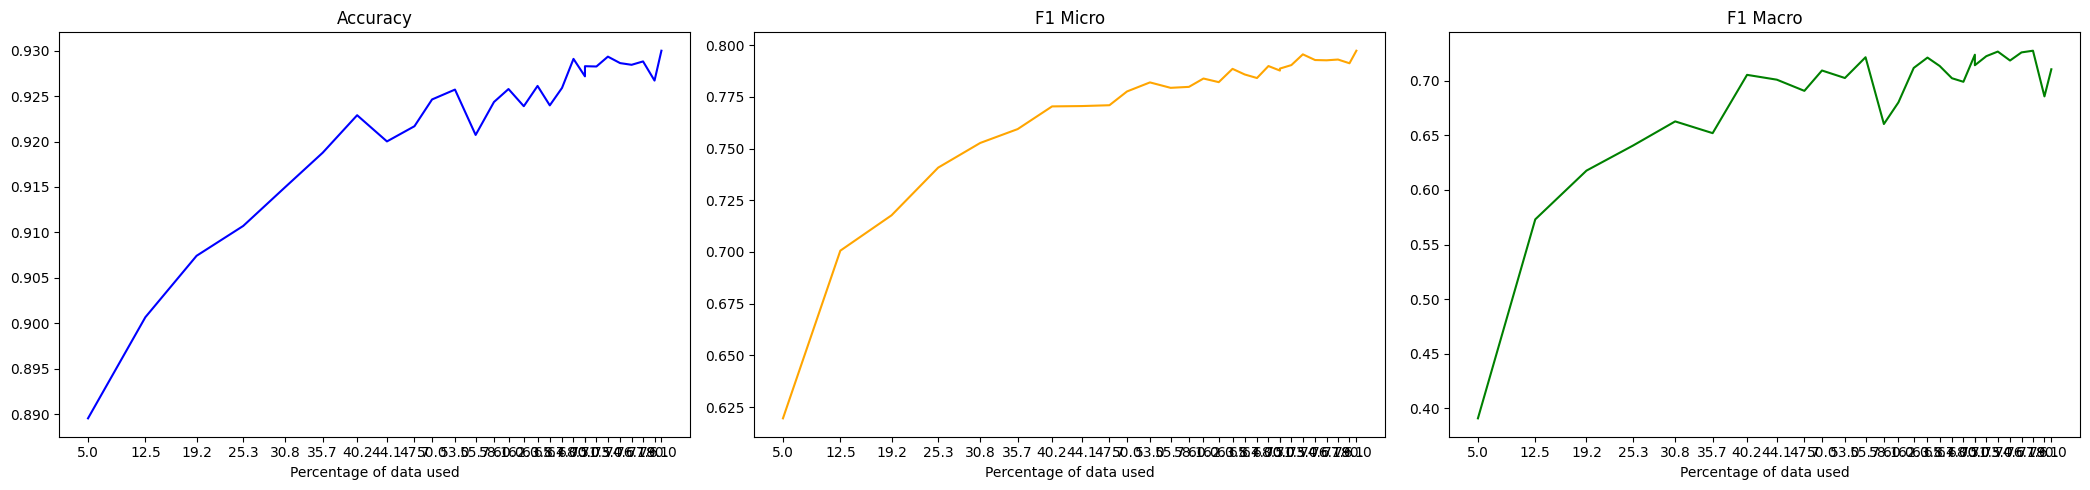

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5519, Accuracy: 0.828, F1 Micro: 0.0267, F1 Macro: 0.0113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4104, Accuracy: 0.8342, F1 Micro: 0.1087, F1 Macro: 0.0403
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3709, Accuracy: 0.8448, F1 Micro: 0.2599, F1 Macro: 0.0878
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3484, Accuracy: 0.8632, F1 Micro: 0.4852, F1 Macro: 0.2064
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3341, Accuracy: 0.8732, F1 Micro: 0.5834, F1 Macro: 0.2692
Epoch 6/10, Train Loss: 0.2942, Accuracy: 0.8779, F1 Micro: 0.5622, F1 Macro: 0.2632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2602, Accuracy: 0.8819, F1 Micro: 0.5948, F1 Macro: 0.285
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2414, Accuracy: 0.8842, F1 Micro: 0.6007, F1 Macro: 0.2979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2191, Accuracy: 0.8873, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5268, Accuracy: 0.8178, F1 Micro: 0.2898, F1 Macro: 0.0607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4305, Accuracy: 0.8698, F1 Micro: 0.542, F1 Macro: 0.3194
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3534, Accuracy: 0.8901, F1 Micro: 0.6227, F1 Macro: 0.4483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.306, Accuracy: 0.8992, F1 Micro: 0.6778, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.254, Accuracy: 0.9026, F1 Micro: 0.6899, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2199, Accuracy: 0.9004, F1 Micro: 0.7115, F1 Macro: 0.573
Epoch 7/10, Train Loss: 0.1955, Accuracy: 0.9031, F1 Micro: 0.7091, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.159, Accuracy: 0.9024, F1 Micro: 0.7121, F1 Macro: 0.5745
Epoch 9/10, Train Loss: 0.1293, Accuracy: 0.9017, F1 Micro: 0.7027, F1 Macro: 0.5759
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4845, Accuracy: 0.8347, F1 Micro: 0.5026, F1 Macro: 0.2337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3656, Accuracy: 0.889, F1 Micro: 0.6598, F1 Macro: 0.4652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.308, Accuracy: 0.9008, F1 Micro: 0.6909, F1 Macro: 0.528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2607, Accuracy: 0.9043, F1 Micro: 0.7091, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2165, Accuracy: 0.9085, F1 Micro: 0.7138, F1 Macro: 0.5812
Epoch 6/10, Train Loss: 0.1806, Accuracy: 0.9081, F1 Micro: 0.6911, F1 Macro: 0.5811
Epoch 7/10, Train Loss: 0.1486, Accuracy: 0.9093, F1 Micro: 0.7052, F1 Macro: 0.6017
Epoch 8/10, Train Loss: 0.128, Accuracy: 0.9086, F1 Micro: 0.6963, F1 Macro: 0.6134
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1029, Accuracy: 0.908, F1 Micro: 0.7338, F1 Macro: 0.6343
Epoch 10/10, Train Loss: 0.0933, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.436, Accuracy: 0.8768, F1 Micro: 0.61, F1 Macro: 0.2994
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3003, Accuracy: 0.8959, F1 Micro: 0.6824, F1 Macro: 0.496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2479, Accuracy: 0.9053, F1 Micro: 0.6929, F1 Macro: 0.5274
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2108, Accuracy: 0.9073, F1 Micro: 0.7276, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1688, Accuracy: 0.9105, F1 Micro: 0.7323, F1 Macro: 0.591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.9109, F1 Micro: 0.7382, F1 Macro: 0.6171
Epoch 7/10, Train Loss: 0.1202, Accuracy: 0.9124, F1 Micro: 0.736, F1 Macro: 0.6272
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0959, Accuracy: 0.913, F1 Micro: 0.7384, F1 Macro: 0.6506
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9111, F1 Micro: 0.7275, F1 Macro: 0.6436
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4151, Accuracy: 0.8836, F1 Micro: 0.6451, F1 Macro: 0.3413
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2817, Accuracy: 0.9005, F1 Micro: 0.6741, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2234, Accuracy: 0.9041, F1 Micro: 0.7136, F1 Macro: 0.5526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.9079, F1 Micro: 0.7291, F1 Macro: 0.5961
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9123, F1 Micro: 0.7205, F1 Macro: 0.5683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9102, F1 Micro: 0.7414, F1 Macro: 0.6281
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.914, F1 Micro: 0.7356, F1 Macro: 0.6602
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9142, F1 Micro: 0.7471, F1 Macro: 0.6784
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9135, F1 Micro: 0.7454, F1 Macro: 0.6775
Epoch 10/10, Train Loss: 0.0653, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8698, F1 Micro: 0.6569, F1 Macro: 0.3797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.9027, F1 Micro: 0.7061, F1 Macro: 0.5412
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2057, Accuracy: 0.9105, F1 Micro: 0.7248, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9154, F1 Micro: 0.74, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.9153, F1 Micro: 0.7474, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9137, F1 Micro: 0.7518, F1 Macro: 0.6619
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.915, F1 Micro: 0.73, F1 Macro: 0.6551
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9173, F1 Micro: 0.7458, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9175, F1 Micro: 0.7522, F1 Macro: 0.6803
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3663, Accuracy: 0.886, F1 Micro: 0.5928, F1 Macro: 0.3277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2316, Accuracy: 0.9051, F1 Micro: 0.7019, F1 Macro: 0.5346
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1835, Accuracy: 0.9109, F1 Micro: 0.7181, F1 Macro: 0.5665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.913, F1 Micro: 0.7434, F1 Macro: 0.6074
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.9172, F1 Micro: 0.7386, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9156, F1 Micro: 0.7499, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0862, Accuracy: 0.9179, F1 Micro: 0.7536, F1 Macro: 0.672
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.916, F1 Micro: 0.7492, F1 Macro: 0.6684
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9164, F1 Micro: 0.753, F1 Macro: 0.6869
Epoch 10/10, Train Loss: 0.0515, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3763, Accuracy: 0.8955, F1 Micro: 0.6625, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.9082, F1 Micro: 0.7002, F1 Macro: 0.495
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.9126, F1 Micro: 0.7502, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9186, F1 Micro: 0.7574, F1 Macro: 0.6409
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.918, F1 Micro: 0.7517, F1 Macro: 0.6356
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.921, F1 Micro: 0.7571, F1 Macro: 0.6662
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9187, F1 Micro: 0.7593, F1 Macro: 0.6795
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9193, F1 Micro: 0.7518, F1 Macro: 0.6585
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9197, F1 Micro: 0.7686, F1 Macro: 0.7038
Epoch 10/10, Train Loss: 0.0515, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.8974, F1 Micro: 0.6797, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2349, Accuracy: 0.9122, F1 Micro: 0.7336, F1 Macro: 0.5597
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9145, F1 Micro: 0.7141, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9204, F1 Micro: 0.7558, F1 Macro: 0.6087
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9203, F1 Micro: 0.7537, F1 Macro: 0.6665
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9196, F1 Micro: 0.7619, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9175, F1 Micro: 0.7621, F1 Macro: 0.6933
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9189, F1 Micro: 0.7551, F1 Macro: 0.6913
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9174, F1 Micro: 0.7398, F1 Macro: 0.6793
Epoch 10/10, Train Loss: 0.0526, Accuracy: 0.9165, F1 Micro: 0.7554, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3587, Accuracy: 0.8955, F1 Micro: 0.6519, F1 Macro: 0.4431
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2332, Accuracy: 0.9085, F1 Micro: 0.732, F1 Macro: 0.5428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9185, F1 Micro: 0.7557, F1 Macro: 0.6105
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9187, F1 Micro: 0.7465, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9191, F1 Micro: 0.7696, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9217, F1 Micro: 0.7713, F1 Macro: 0.6962
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.92, F1 Micro: 0.757, F1 Macro: 0.6841
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9204, F1 Micro: 0.7584, F1 Macro: 0.6878
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9196, F1 Micro: 0.7588, F1 Macro: 0.6912
Epoch 10/10, Train Loss: 0.0475, Accuracy: 0.9158, F1 Micro: 0.7621, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3591, Accuracy: 0.8984, F1 Micro: 0.651, F1 Macro: 0.4049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2291, Accuracy: 0.9104, F1 Micro: 0.7442, F1 Macro: 0.5782
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9205, F1 Micro: 0.742, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9214, F1 Micro: 0.7672, F1 Macro: 0.6339
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.92, F1 Micro: 0.766, F1 Macro: 0.6796
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9239, F1 Micro: 0.7663, F1 Macro: 0.6913
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9223, F1 Micro: 0.7728, F1 Macro: 0.6822
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9231, F1 Micro: 0.7714, F1 Macro: 0.6969
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9229, F1 Micro: 0.7773, F1 Macro: 0.7061
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.9209, F1 Micro: 0.77, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.9005, F1 Micro: 0.6922, F1 Macro: 0.4483
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2235, Accuracy: 0.9106, F1 Micro: 0.7328, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.915, F1 Micro: 0.7547, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9185, F1 Micro: 0.765, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.9221, F1 Micro: 0.769, F1 Macro: 0.686
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9212, F1 Micro: 0.7567, F1 Macro: 0.6756
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9195, F1 Micro: 0.7619, F1 Macro: 0.6846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9215, F1 Micro: 0.7711, F1 Macro: 0.7056
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.922, F1 Micro: 0.7626, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3488, Accuracy: 0.9022, F1 Micro: 0.7006, F1 Macro: 0.4563
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.224, Accuracy: 0.9134, F1 Micro: 0.7374, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9189, F1 Micro: 0.7627, F1 Macro: 0.6287
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.924, F1 Micro: 0.7603, F1 Macro: 0.6267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.925, F1 Micro: 0.7659, F1 Macro: 0.6798
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9215, F1 Micro: 0.752, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9241, F1 Micro: 0.7766, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9256, F1 Micro: 0.778, F1 Macro: 0.7055
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.924, F1 Micro: 0.7722, F1 Macro: 0.7076
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3404, Accuracy: 0.9025, F1 Micro: 0.6962, F1 Macro: 0.4652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2211, Accuracy: 0.9129, F1 Micro: 0.7359, F1 Macro: 0.5577
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1768, Accuracy: 0.9195, F1 Micro: 0.7567, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9219, F1 Micro: 0.769, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9237, F1 Micro: 0.7769, F1 Macro: 0.6911
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9223, F1 Micro: 0.7653, F1 Macro: 0.6797
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9217, F1 Micro: 0.7759, F1 Macro: 0.7017
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9206, F1 Micro: 0.7705, F1 Macro: 0.7072
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9233, F1 Micro: 0.7759, F1 Macro: 0.7204
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.9227, F1 Micro: 0.7631, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3436, Accuracy: 0.8999, F1 Micro: 0.6553, F1 Macro: 0.4058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2176, Accuracy: 0.9123, F1 Micro: 0.7501, F1 Macro: 0.5888
Epoch 3/10, Train Loss: 0.1774, Accuracy: 0.9199, F1 Micro: 0.7386, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9198, F1 Micro: 0.7736, F1 Macro: 0.666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9238, F1 Micro: 0.7796, F1 Macro: 0.6931
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.923, F1 Micro: 0.7664, F1 Macro: 0.6962
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9228, F1 Micro: 0.7761, F1 Macro: 0.7075
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9238, F1 Micro: 0.7719, F1 Macro: 0.7052
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9244, F1 Micro: 0.773, F1 Macro: 0.7081
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.9198, F1 Micro: 0.7728, F1 Macro: 0.7154

 Iteration 8165: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3364, Accuracy: 0.9036, F1 Micro: 0.6947, F1 Macro: 0.4821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2181, Accuracy: 0.9159, F1 Micro: 0.7381, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9222, F1 Micro: 0.7693, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.925, F1 Micro: 0.78, F1 Macro: 0.6847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1095, Accuracy: 0.9247, F1 Micro: 0.783, F1 Macro: 0.7009
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9231, F1 Micro: 0.7741, F1 Macro: 0.6983
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9211, F1 Micro: 0.7764, F1 Macro: 0.7099
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9229, F1 Micro: 0.7711, F1 Macro: 0.7043
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9213, F1 Micro: 0.7697, F1 Macro: 0.7061
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.924, F1 Micro: 0.7708, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3379, Accuracy: 0.9023, F1 Micro: 0.7049, F1 Macro: 0.4722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2161, Accuracy: 0.9155, F1 Micro: 0.7512, F1 Macro: 0.5894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1712, Accuracy: 0.9236, F1 Micro: 0.7755, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.139, Accuracy: 0.9244, F1 Micro: 0.78, F1 Macro: 0.665
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.921, F1 Micro: 0.7772, F1 Macro: 0.6931
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.926, F1 Micro: 0.775, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9247, F1 Micro: 0.7812, F1 Macro: 0.7156
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.922, F1 Micro: 0.777, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9248, F1 Micro: 0.7829, F1 Macro: 0.7171
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3379, Accuracy: 0.9024, F1 Micro: 0.6843, F1 Macro: 0.4684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2211, Accuracy: 0.9155, F1 Micro: 0.7534, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9243, F1 Micro: 0.7713, F1 Macro: 0.6299
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9259, F1 Micro: 0.7712, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9262, F1 Micro: 0.784, F1 Macro: 0.7009
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9206, F1 Micro: 0.7804, F1 Macro: 0.7113
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9239, F1 Micro: 0.7789, F1 Macro: 0.7043
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9229, F1 Micro: 0.7787, F1 Macro: 0.714
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9244, F1 Micro: 0.7791, F1 Macro: 0.7215
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.9238, F1 Micro: 0.7709, F1 Macro: 0.7079

 Iteration 8817: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3405, Accuracy: 0.9034, F1 Micro: 0.6975, F1 Macro: 0.4317
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2206, Accuracy: 0.9178, F1 Micro: 0.7525, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1742, Accuracy: 0.9244, F1 Micro: 0.7797, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.924, F1 Micro: 0.78, F1 Macro: 0.6701
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9254, F1 Micro: 0.774, F1 Macro: 0.6803
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9257, F1 Micro: 0.777, F1 Macro: 0.704
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9231, F1 Micro: 0.7606, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9229, F1 Micro: 0.7832, F1 Macro: 0.7197
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9248, F1 Micro: 0.78, F1 Macro: 0.7129
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9266, F1 Micro: 0.7772, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3382, Accuracy: 0.9048, F1 Micro: 0.7029, F1 Macro: 0.4774
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.9154, F1 Micro: 0.7542, F1 Macro: 0.5783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9227, F1 Micro: 0.7717, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.924, F1 Micro: 0.7819, F1 Macro: 0.6776
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.9257, F1 Micro: 0.7686, F1 Macro: 0.6744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9286, F1 Micro: 0.79, F1 Macro: 0.7188
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9243, F1 Micro: 0.7827, F1 Macro: 0.7159
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9258, F1 Micro: 0.7799, F1 Macro: 0.7157
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9254, F1 Micro: 0.7787, F1 Macro: 0.7118
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.9247, F1 Micro: 0.7659, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3365, Accuracy: 0.9066, F1 Micro: 0.7018, F1 Macro: 0.503
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.217, Accuracy: 0.9153, F1 Micro: 0.746, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9185, F1 Micro: 0.7692, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1405, Accuracy: 0.9254, F1 Micro: 0.7777, F1 Macro: 0.6657
Epoch 5/10, Train Loss: 0.1088, Accuracy: 0.9195, F1 Micro: 0.7681, F1 Macro: 0.6895
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9268, F1 Micro: 0.7858, F1 Macro: 0.7031
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9264, F1 Micro: 0.7842, F1 Macro: 0.7032
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.925, F1 Micro: 0.783, F1 Macro: 0.7154
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.924, F1 Micro: 0.7785, F1 Macro: 0.7134
Epoch 10/10, Train Loss: 0.0428, Accuracy: 0.9224, F1 Micro: 0.7799, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3379, Accuracy: 0.9043, F1 Micro: 0.6941, F1 Macro: 0.4896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.915, F1 Micro: 0.755, F1 Macro: 0.5864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9237, F1 Micro: 0.7786, F1 Macro: 0.6417
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9264, F1 Micro: 0.786, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9287, F1 Micro: 0.789, F1 Macro: 0.7039
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9282, F1 Micro: 0.7916, F1 Macro: 0.7123
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9265, F1 Micro: 0.7885, F1 Macro: 0.7198
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9258, F1 Micro: 0.783, F1 Macro: 0.7119
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9278, F1 Micro: 0.7911, F1 Macro: 0.7297
Epoch 10/10, Train Loss: 0.0405, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.332, Accuracy: 0.9048, F1 Micro: 0.7181, F1 Macro: 0.5044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.9202, F1 Micro: 0.7548, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9243, F1 Micro: 0.767, F1 Macro: 0.6303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.9258, F1 Micro: 0.778, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9245, F1 Micro: 0.7806, F1 Macro: 0.6715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9247, F1 Micro: 0.782, F1 Macro: 0.7129
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.924, F1 Micro: 0.7822, F1 Macro: 0.7129
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9281, F1 Micro: 0.7891, F1 Macro: 0.7279
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9243, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3306, Accuracy: 0.9038, F1 Micro: 0.6788, F1 Macro: 0.4814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2184, Accuracy: 0.9203, F1 Micro: 0.7552, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9251, F1 Micro: 0.7761, F1 Macro: 0.6426
Epoch 4/10, Train Loss: 0.1377, Accuracy: 0.9268, F1 Micro: 0.774, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9255, F1 Micro: 0.7771, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9294, F1 Micro: 0.7925, F1 Macro: 0.7181
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9289, F1 Micro: 0.7869, F1 Macro: 0.719
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9269, F1 Micro: 0.7816, F1 Macro: 0.7157
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9271, F1 Micro: 0.7823, F1 Macro: 0.7176
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.9263, F1 Micro: 0.7819, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.327, Accuracy: 0.908, F1 Micro: 0.712, F1 Macro: 0.4896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9187, F1 Micro: 0.7651, F1 Macro: 0.6005
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9247, F1 Micro: 0.7794, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.133, Accuracy: 0.9259, F1 Micro: 0.7844, F1 Macro: 0.673
Epoch 5/10, Train Loss: 0.109, Accuracy: 0.9269, F1 Micro: 0.7823, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9276, F1 Micro: 0.7848, F1 Macro: 0.7075
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9255, F1 Micro: 0.7774, F1 Macro: 0.7173
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.9273, F1 Micro: 0.7868, F1 Macro: 0.7235
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.924, F1 Micro: 0.7773, F1 Macro: 0.7173
Epoch 10/10, Train Loss: 0.0406, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3335, Accuracy: 0.9058, F1 Micro: 0.7041, F1 Macro: 0.4993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.9163, F1 Micro: 0.7574, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9262, F1 Micro: 0.7759, F1 Macro: 0.6273
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9258, F1 Micro: 0.7816, F1 Macro: 0.6524
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9255, F1 Micro: 0.7858, F1 Macro: 0.709
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9263, F1 Micro: 0.7773, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9274, F1 Micro: 0.7881, F1 Macro: 0.7177
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9258, F1 Micro: 0.7839, F1 Macro: 0.7164
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9299, F1 Micro: 0.7864, F1 Macro: 0.7272
Epoch 10/10, Train Loss: 0.0436, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3231, Accuracy: 0.9083, F1 Micro: 0.7196, F1 Macro: 0.5127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2154, Accuracy: 0.9187, F1 Micro: 0.7595, F1 Macro: 0.5748
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.9268, F1 Micro: 0.7754, F1 Macro: 0.647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9271, F1 Micro: 0.7847, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9293, F1 Micro: 0.7921, F1 Macro: 0.712
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.925, F1 Micro: 0.785, F1 Macro: 0.7154
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9288, F1 Micro: 0.7772, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9305, F1 Micro: 0.793, F1 Macro: 0.7243
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9292, F1 Micro: 0.7899, F1 Macro: 0.7246
Epoch 10/10, Train Loss: 0.0403, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3256, Accuracy: 0.8965, F1 Micro: 0.6226, F1 Macro: 0.3758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2156, Accuracy: 0.9189, F1 Micro: 0.7608, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9249, F1 Micro: 0.7761, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1335, Accuracy: 0.9277, F1 Micro: 0.7824, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1065, Accuracy: 0.9275, F1 Micro: 0.791, F1 Macro: 0.7041
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9295, F1 Micro: 0.7907, F1 Macro: 0.7071
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9287, F1 Micro: 0.7922, F1 Macro: 0.7255
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9284, F1 Micro: 0.7867, F1 Macro: 0.7254
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9249, F1 Micro: 0.7867, F1 Macro: 0.7253
Epoch 10/10, Train Loss: 0.0398, Accura

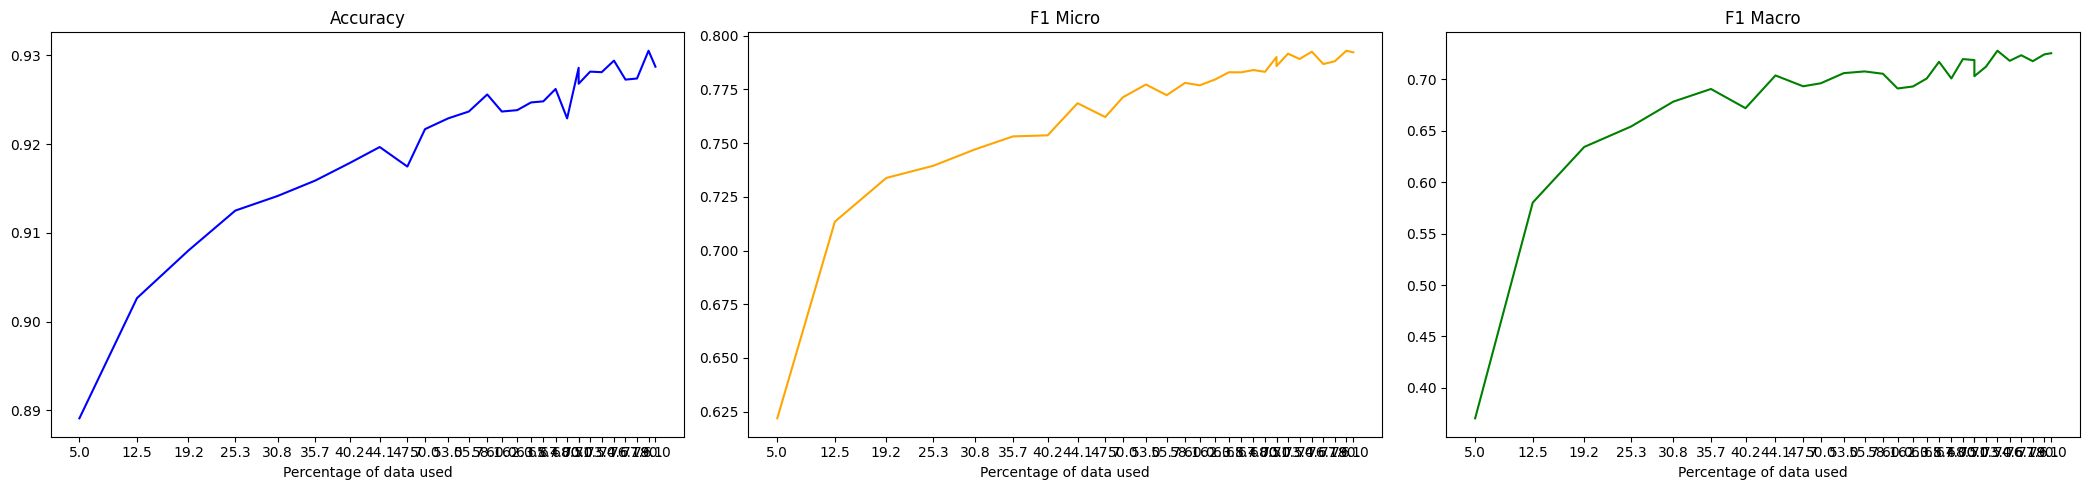

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5555, Accuracy: 0.8337, F1 Micro: 0.1221, F1 Macro: 0.0455
Epoch 2/10, Train Loss: 0.412, Accuracy: 0.8331, F1 Micro: 0.093, F1 Macro: 0.0357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3838, Accuracy: 0.85, F1 Micro: 0.3324, F1 Macro: 0.1045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.361, Accuracy: 0.8623, F1 Micro: 0.4364, F1 Macro: 0.1744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3354, Accuracy: 0.8743, F1 Micro: 0.5172, F1 Macro: 0.2393
Epoch 6/10, Train Loss: 0.2895, Accuracy: 0.8755, F1 Micro: 0.5149, F1 Macro: 0.2388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2746, Accuracy: 0.8809, F1 Micro: 0.5603, F1 Macro: 0.2862
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2369, Accuracy: 0.8823, F1 Micro: 0.5656, F1 Macro: 0.3136
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2069, Accuracy: 0.8868, F1 Micro: 0.619, F1 Macro: 0.3533
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5024, Accuracy: 0.8093, F1 Micro: 0.5139, F1 Macro: 0.2273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.398, Accuracy: 0.8787, F1 Micro: 0.5982, F1 Macro: 0.3505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3359, Accuracy: 0.893, F1 Micro: 0.6657, F1 Macro: 0.4425
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2856, Accuracy: 0.8993, F1 Micro: 0.6766, F1 Macro: 0.491
Epoch 5/10, Train Loss: 0.2443, Accuracy: 0.9005, F1 Micro: 0.6606, F1 Macro: 0.4652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2112, Accuracy: 0.9014, F1 Micro: 0.6876, F1 Macro: 0.5289
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1792, Accuracy: 0.9016, F1 Micro: 0.688, F1 Macro: 0.5415
Epoch 8/10, Train Loss: 0.1545, Accuracy: 0.9004, F1 Micro: 0.6797, F1 Macro: 0.5549
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1313, Accuracy: 0.8987, F1 Micro: 0.7052, F1 Macro: 0.5675
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4569, Accuracy: 0.8587, F1 Micro: 0.55, F1 Macro: 0.2483
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3401, Accuracy: 0.8921, F1 Micro: 0.6739, F1 Macro: 0.4155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2804, Accuracy: 0.8996, F1 Micro: 0.6801, F1 Macro: 0.4259
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2387, Accuracy: 0.8927, F1 Micro: 0.7092, F1 Macro: 0.5139
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2031, Accuracy: 0.9065, F1 Micro: 0.7234, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1748, Accuracy: 0.9117, F1 Micro: 0.729, F1 Macro: 0.5755
Epoch 7/10, Train Loss: 0.1388, Accuracy: 0.9108, F1 Micro: 0.7199, F1 Macro: 0.5573
Epoch 8/10, Train Loss: 0.119, Accuracy: 0.9123, F1 Micro: 0.7271, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0974, Accuracy: 0.912, F1 Micro: 0.7298, F1 Macro: 0.5978
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4603, Accuracy: 0.8704, F1 Micro: 0.608, F1 Macro: 0.3439
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.334, Accuracy: 0.9023, F1 Micro: 0.6829, F1 Macro: 0.5011
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2789, Accuracy: 0.9038, F1 Micro: 0.7249, F1 Macro: 0.5515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2241, Accuracy: 0.9145, F1 Micro: 0.7291, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1882, Accuracy: 0.9146, F1 Micro: 0.7303, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1501, Accuracy: 0.9099, F1 Micro: 0.7445, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.9148, F1 Micro: 0.7462, F1 Macro: 0.624
Epoch 8/10, Train Loss: 0.1075, Accuracy: 0.915, F1 Micro: 0.744, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0939, Accuracy: 0.9161, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4401, Accuracy: 0.8815, F1 Micro: 0.6396, F1 Macro: 0.366
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3128, Accuracy: 0.9037, F1 Micro: 0.6936, F1 Macro: 0.5189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.256, Accuracy: 0.9116, F1 Micro: 0.7398, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2148, Accuracy: 0.9158, F1 Micro: 0.7456, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1751, Accuracy: 0.9135, F1 Micro: 0.7514, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.919, F1 Micro: 0.7596, F1 Macro: 0.6446
Epoch 7/10, Train Loss: 0.1247, Accuracy: 0.9178, F1 Micro: 0.7472, F1 Macro: 0.6427
Epoch 8/10, Train Loss: 0.1001, Accuracy: 0.9195, F1 Micro: 0.7583, F1 Macro: 0.6728
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9189, F1 Micro: 0.7549, F1 Macro: 0.675
Epoch 10/10, Train Loss: 0.0684, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4091, Accuracy: 0.8903, F1 Micro: 0.6616, F1 Macro: 0.4119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2799, Accuracy: 0.9077, F1 Micro: 0.7066, F1 Macro: 0.5313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9105, F1 Micro: 0.7428, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9187, F1 Micro: 0.7455, F1 Macro: 0.6105
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9171, F1 Micro: 0.7485, F1 Macro: 0.6225
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9181, F1 Micro: 0.7304, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9163, F1 Micro: 0.7558, F1 Macro: 0.6653
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9151, F1 Micro: 0.7531, F1 Macro: 0.6719
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9172, F1 Micro: 0.7585, F1 Macro: 0.6833
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3919, Accuracy: 0.8932, F1 Micro: 0.6747, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.9083, F1 Micro: 0.7258, F1 Macro: 0.5258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9122, F1 Micro: 0.7481, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9186, F1 Micro: 0.7584, F1 Macro: 0.6298
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.919, F1 Micro: 0.7629, F1 Macro: 0.6413
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.917, F1 Micro: 0.7611, F1 Macro: 0.6731
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9176, F1 Micro: 0.757, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9216, F1 Micro: 0.7656, F1 Macro: 0.6671
Epoch 9/10, Train Loss: 0.0672, Accuracy: 0.9181, F1 Micro: 0.7623, F1 Macro: 0.6932
Epoch 10/10, Train Loss: 0.0583, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8888, F1 Micro: 0.6853, F1 Macro: 0.4389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2628, Accuracy: 0.9098, F1 Micro: 0.7227, F1 Macro: 0.5422
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2121, Accuracy: 0.9197, F1 Micro: 0.746, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9192, F1 Micro: 0.7609, F1 Macro: 0.6089
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9184, F1 Micro: 0.7661, F1 Macro: 0.6371
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9195, F1 Micro: 0.7628, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9201, F1 Micro: 0.7693, F1 Macro: 0.6753
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9189, F1 Micro: 0.7688, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.92, F1 Micro: 0.7697, F1 Macro: 0.6947
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3902, Accuracy: 0.8959, F1 Micro: 0.6764, F1 Macro: 0.4315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.265, Accuracy: 0.9123, F1 Micro: 0.7408, F1 Macro: 0.5571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2124, Accuracy: 0.9194, F1 Micro: 0.7632, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9193, F1 Micro: 0.7676, F1 Macro: 0.6359
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9213, F1 Micro: 0.7643, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.9209, F1 Micro: 0.7689, F1 Macro: 0.6729
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9219, F1 Micro: 0.7577, F1 Macro: 0.676
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9194, F1 Micro: 0.7625, F1 Macro: 0.6801
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9187, F1 Micro: 0.7667, F1 Macro: 0.6961
Epoch 10/10, Train Loss: 0.0569, Accuracy: 0.9205, F1 Micro: 0.768, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3876, Accuracy: 0.8986, F1 Micro: 0.6937, F1 Macro: 0.5123
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9124, F1 Micro: 0.7312, F1 Macro: 0.5401
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9168, F1 Micro: 0.7245, F1 Macro: 0.5569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9217, F1 Micro: 0.7737, F1 Macro: 0.6554
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9251, F1 Micro: 0.7731, F1 Macro: 0.6812
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9191, F1 Micro: 0.7701, F1 Macro: 0.6587
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9198, F1 Micro: 0.7673, F1 Macro: 0.6968
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9213, F1 Micro: 0.7724, F1 Macro: 0.7036
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9219, F1 Micro: 0.765, F1 Macro: 0.6995
Epoch 10/10, Train Loss: 0.0566, Accuracy: 0.9211, F1 Micro: 0.769, F1 Macro: 0.7033

 Iteration 6584: Accuracy: 0.9217, F1 Micro: 0.7737,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.9013, F1 Micro: 0.6859, F1 Macro: 0.4864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2588, Accuracy: 0.9136, F1 Micro: 0.7296, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9223, F1 Micro: 0.7605, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9246, F1 Micro: 0.772, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9269, F1 Micro: 0.7852, F1 Macro: 0.6937
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9251, F1 Micro: 0.773, F1 Macro: 0.6899
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9253, F1 Micro: 0.7778, F1 Macro: 0.6825
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9252, F1 Micro: 0.7755, F1 Macro: 0.7104
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.918, F1 Micro: 0.7736, F1 Macro: 0.7141
Epoch 10/10, Train Loss: 0.0556, Accuracy: 0.9215, F1 Micro: 0.7781, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8928, F1 Micro: 0.6854, F1 Macro: 0.4233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.9178, F1 Micro: 0.7449, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.923, F1 Micro: 0.7724, F1 Macro: 0.6199
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9224, F1 Micro: 0.7671, F1 Macro: 0.632
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.924, F1 Micro: 0.7653, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.924, F1 Micro: 0.7773, F1 Macro: 0.6888
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9231, F1 Micro: 0.7639, F1 Macro: 0.6795
Epoch 8/10, Train Loss: 0.0771, Accuracy: 0.9244, F1 Micro: 0.7762, F1 Macro: 0.7072
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9262, F1 Micro: 0.7839, F1 Macro: 0.7123
Epoch 10/10, Train Loss: 0.0516, Accuracy: 0.9228, F1 Micro: 0.7798, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3691, Accuracy: 0.9031, F1 Micro: 0.7082, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2474, Accuracy: 0.9176, F1 Micro: 0.7591, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.918, F1 Micro: 0.771, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9238, F1 Micro: 0.7797, F1 Macro: 0.6513
Epoch 5/10, Train Loss: 0.1306, Accuracy: 0.9252, F1 Micro: 0.7672, F1 Macro: 0.6771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1092, Accuracy: 0.9241, F1 Micro: 0.7841, F1 Macro: 0.6862
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9245, F1 Micro: 0.7784, F1 Macro: 0.7028
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9242, F1 Micro: 0.7773, F1 Macro: 0.7043
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9243, F1 Micro: 0.7778, F1 Macro: 0.7154
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.9229, F1 Micro: 0.7786, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.361, Accuracy: 0.9016, F1 Micro: 0.6987, F1 Macro: 0.4542
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.9169, F1 Micro: 0.7506, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9228, F1 Micro: 0.771, F1 Macro: 0.6151
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9227, F1 Micro: 0.7766, F1 Macro: 0.6587
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9262, F1 Micro: 0.7763, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9265, F1 Micro: 0.7773, F1 Macro: 0.697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9255, F1 Micro: 0.788, F1 Macro: 0.7075
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9238, F1 Micro: 0.7769, F1 Macro: 0.709
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9227, F1 Micro: 0.7806, F1 Macro: 0.7154
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3657, Accuracy: 0.901, F1 Micro: 0.67, F1 Macro: 0.4289
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9162, F1 Micro: 0.7535, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9197, F1 Micro: 0.7678, F1 Macro: 0.6246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9246, F1 Micro: 0.7806, F1 Macro: 0.676
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9265, F1 Micro: 0.7806, F1 Macro: 0.6932
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9253, F1 Micro: 0.7788, F1 Macro: 0.6913
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9264, F1 Micro: 0.7768, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9244, F1 Micro: 0.7808, F1 Macro: 0.7097
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9261, F1 Micro: 0.7744, F1 Macro: 0.7021
Epoch 10/10, Train Loss: 0.049, Accuracy: 0.9264, F1 Micro: 0.7797, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3612, Accuracy: 0.905, F1 Micro: 0.694, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.9178, F1 Micro: 0.7589, F1 Macro: 0.591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1888, Accuracy: 0.9247, F1 Micro: 0.7761, F1 Macro: 0.6186
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9238, F1 Micro: 0.7585, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.9264, F1 Micro: 0.7832, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.928, F1 Micro: 0.7838, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9275, F1 Micro: 0.7863, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9275, F1 Micro: 0.7884, F1 Macro: 0.7249
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.918, F1 Micro: 0.774, F1 Macro: 0.7093
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3566, Accuracy: 0.8911, F1 Micro: 0.7085, F1 Macro: 0.532
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2395, Accuracy: 0.9133, F1 Micro: 0.7574, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9246, F1 Micro: 0.7689, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9248, F1 Micro: 0.7827, F1 Macro: 0.6546
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9257, F1 Micro: 0.7782, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.926, F1 Micro: 0.7838, F1 Macro: 0.6888
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9225, F1 Micro: 0.7812, F1 Macro: 0.703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9284, F1 Micro: 0.7872, F1 Macro: 0.7064
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.9232, F1 Micro: 0.7863, F1 Macro: 0.7228
Epoch 10/10, Train Loss: 0.0462, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3566, Accuracy: 0.9041, F1 Micro: 0.6983, F1 Macro: 0.4615
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9172, F1 Micro: 0.7565, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9246, F1 Micro: 0.7733, F1 Macro: 0.6262
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9282, F1 Micro: 0.7846, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9298, F1 Micro: 0.7866, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9259, F1 Micro: 0.7871, F1 Macro: 0.7088
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9236, F1 Micro: 0.7835, F1 Macro: 0.7128
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9289, F1 Micro: 0.7851, F1 Macro: 0.7063
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9276, F1 Micro: 0.7831, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3569, Accuracy: 0.9054, F1 Micro: 0.6898, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9187, F1 Micro: 0.7603, F1 Macro: 0.5988
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1884, Accuracy: 0.9249, F1 Micro: 0.7771, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9264, F1 Micro: 0.7865, F1 Macro: 0.694
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9256, F1 Micro: 0.7827, F1 Macro: 0.6949
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9286, F1 Micro: 0.788, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9288, F1 Micro: 0.7914, F1 Macro: 0.7218
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9273, F1 Micro: 0.7911, F1 Macro: 0.7242
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9294, F1 Micro: 0.7905, F1 Macro: 0.7331
Epoch 10/10, Train Loss: 0.0477, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3477, Accuracy: 0.9072, F1 Micro: 0.7203, F1 Macro: 0.5125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.237, Accuracy: 0.9187, F1 Micro: 0.7575, F1 Macro: 0.5715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.922, F1 Micro: 0.7783, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9256, F1 Micro: 0.7866, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9274, F1 Micro: 0.7951, F1 Macro: 0.7017
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9271, F1 Micro: 0.7882, F1 Macro: 0.7136
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9275, F1 Micro: 0.7858, F1 Macro: 0.7098
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9246, F1 Micro: 0.7727, F1 Macro: 0.7072
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9262, F1 Micro: 0.7872, F1 Macro: 0.7195
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.9279, F1 Micro: 0.791, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3518, Accuracy: 0.8995, F1 Micro: 0.6816, F1 Macro: 0.3654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9202, F1 Micro: 0.7566, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.9215, F1 Micro: 0.7779, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9275, F1 Micro: 0.7893, F1 Macro: 0.6599
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9295, F1 Micro: 0.7833, F1 Macro: 0.6795
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9253, F1 Micro: 0.7855, F1 Macro: 0.7027
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9259, F1 Micro: 0.7755, F1 Macro: 0.7032
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9278, F1 Micro: 0.7873, F1 Macro: 0.7197
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9261, F1 Micro: 0.788, F1 Macro: 0.7282
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.9267, F1 Micro: 0.7808, F1 Macro: 0.7118

 Iteration 9218: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3502, Accuracy: 0.9055, F1 Micro: 0.7019, F1 Macro: 0.4698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.237, Accuracy: 0.9204, F1 Micro: 0.7591, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9251, F1 Micro: 0.7698, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9272, F1 Micro: 0.7884, F1 Macro: 0.693
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9256, F1 Micro: 0.7872, F1 Macro: 0.6897
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9272, F1 Micro: 0.7863, F1 Macro: 0.6975
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9245, F1 Micro: 0.7845, F1 Macro: 0.7186
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.9238, F1 Micro: 0.7847, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9285, F1 Micro: 0.7891, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0455, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3416, Accuracy: 0.9044, F1 Micro: 0.7051, F1 Macro: 0.4971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2335, Accuracy: 0.9142, F1 Micro: 0.756, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9233, F1 Micro: 0.7576, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9245, F1 Micro: 0.7861, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9276, F1 Micro: 0.7927, F1 Macro: 0.7071
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9261, F1 Micro: 0.7875, F1 Macro: 0.7147
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9271, F1 Micro: 0.7889, F1 Macro: 0.7189
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9293, F1 Micro: 0.788, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9295, F1 Micro: 0.7938, F1 Macro: 0.7224
Epoch 10/10, Train Loss: 0.0483, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3384, Accuracy: 0.905, F1 Micro: 0.6912, F1 Macro: 0.4348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2285, Accuracy: 0.9216, F1 Micro: 0.7626, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.924, F1 Micro: 0.7743, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.9267, F1 Micro: 0.7856, F1 Macro: 0.663
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9264, F1 Micro: 0.7827, F1 Macro: 0.6883
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9278, F1 Micro: 0.7891, F1 Macro: 0.7114
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.924, F1 Micro: 0.7835, F1 Macro: 0.7081
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9292, F1 Micro: 0.7879, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9252, F1 Micro: 0.7866, F1 Macro: 0.7191
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.9299, F1 Micro: 0.7879, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3328, Accuracy: 0.9008, F1 Micro: 0.6471, F1 Macro: 0.4187
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.9183, F1 Micro: 0.7579, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9271, F1 Micro: 0.7766, F1 Macro: 0.6313
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9277, F1 Micro: 0.7838, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9289, F1 Micro: 0.7885, F1 Macro: 0.692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9282, F1 Micro: 0.793, F1 Macro: 0.7241
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9277, F1 Micro: 0.7873, F1 Macro: 0.7173
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9287, F1 Micro: 0.7934, F1 Macro: 0.7226
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9257, F1 Micro: 0.7881, F1 Macro: 0.7202
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3297, Accuracy: 0.9054, F1 Micro: 0.7083, F1 Macro: 0.4563
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2209, Accuracy: 0.9154, F1 Micro: 0.7429, F1 Macro: 0.5447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9228, F1 Micro: 0.7784, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1396, Accuracy: 0.9264, F1 Micro: 0.7837, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.925, F1 Micro: 0.7862, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9267, F1 Micro: 0.7881, F1 Macro: 0.7007
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9297, F1 Micro: 0.786, F1 Macro: 0.7058
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9256, F1 Micro: 0.7822, F1 Macro: 0.7172
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9262, F1 Micro: 0.7866, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3294, Accuracy: 0.9061, F1 Micro: 0.7124, F1 Macro: 0.5016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2192, Accuracy: 0.9206, F1 Micro: 0.7468, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.9242, F1 Micro: 0.7822, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9292, F1 Micro: 0.7893, F1 Macro: 0.6717
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9251, F1 Micro: 0.7848, F1 Macro: 0.6975
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9255, F1 Micro: 0.7854, F1 Macro: 0.711
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9275, F1 Micro: 0.7864, F1 Macro: 0.7119
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9276, F1 Micro: 0.7876, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9289, F1 Micro: 0.7938, F1 Macro: 0.728
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9257, F1 Micro: 0.7799, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3257, Accuracy: 0.9058, F1 Micro: 0.6968, F1 Macro: 0.452
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2169, Accuracy: 0.9229, F1 Micro: 0.7677, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9262, F1 Micro: 0.7726, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9253, F1 Micro: 0.7827, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.9267, F1 Micro: 0.7893, F1 Macro: 0.69
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.9237, F1 Micro: 0.7798, F1 Macro: 0.6919
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.9277, F1 Micro: 0.7868, F1 Macro: 0.711
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.928, F1 Micro: 0.7875, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.047, Accuracy: 0.9295, F1 Micro: 0.7921, F1 Macro: 0.7215
Epoch 10/10, Train Loss: 0.0401, Accuracy: 0

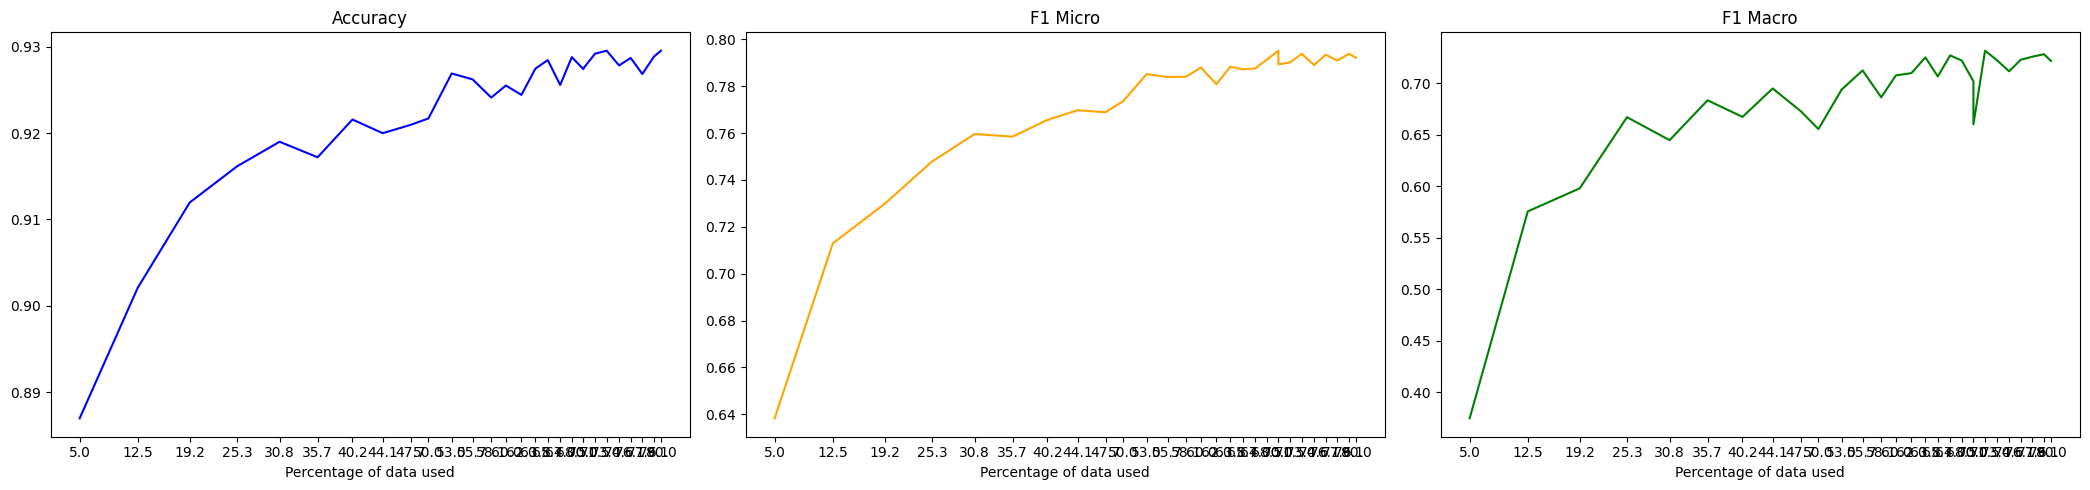

In [ ]:
active_learning(seeds[4], 4)